# GPU

In [ ]:
# The GPU provided has 12GB of memory. However, sometimes the memory of your GPU is shared with other users. At that situation you won’t be able to train your model properly. 
# To make sure that the current GPU memory utilization is 0, run the code below:

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=e0ec35b3786b0ded97cd6d1c2cb1879041dde9144a4b3b6dfe9de4290b9ea620
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 12.3 GB  | Proc size: 96.1 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


In [ ]:
# If the utilization is greater than 0% try to kill your machine, using the code below. This might not work on your first attempt and you can try this multiple times.

!kill -9 -1

In [ ]:
# Updating your data
# Once your Drive is mounted, any change to your drive directory (editing code, adding files, etc.) will not be encountered by Colab. This is due to Colab caching mechanism. 
# To overcome this, you should clear the cache before using your new files, using:

!google-drive-ocamlfuse -cc

/bin/bash: google-drive-ocamlfuse: command not found


# LRFinder definition

code source: https://github.com/titu1994/keras-one-cycle

In [ ]:
import os
import numpy as np
import warnings

from keras.callbacks import Callback
from keras import backend as K


# Code is ported from https://github.com/fastai/fastai
class OneCycleLR(Callback):
    def __init__(self,
                 num_samples,
                 batch_size,
                 max_lr,
                 end_percentage=0.1,
                 scale_percentage=None,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.
        # Arguments:
            num_samples: Integer. Number of samples in the dataset.
            batch_size: Integer. Batch size during training.
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.
        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")

        if scale_percentage is not None and (scale_percentage < 0. or scale_percentage > 1.):
            raise ValueError("`scale_percentage` must be between 0 and 1")

        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = float(scale_percentage) if scale_percentage is not None else float(end_percentage)
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = None
        self.batch_size = batch_size
        self.samples = num_samples
        self.steps = None
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.
        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.
        # Returns:
            the new learning rate
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            current_percentage = (self.clr_iterations - 2 * self.mid_cycle_id)
            current_percentage /= float((self.num_iterations - 2 * self.mid_cycle_id))
            new_lr = self.initial_lr * (1. + (current_percentage *
                                              (1. - 100.) / 100.)) * self.scale

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - (
                self.clr_iterations - self.mid_cycle_id) / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        else:
            current_percentage = self.clr_iterations / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        if self.clr_iterations == self.num_iterations:
            self.clr_iterations = 0

        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.
        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.
        # Returns:
            the new momentum value
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            new_momentum = self.max_momentum

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - ((self.clr_iterations - self.mid_cycle_id) / float(
                                        self.mid_cycle_id))
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        else:
            current_percentage = self.clr_iterations / float(self.mid_cycle_id)
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        self.epochs = self.params['epochs']
        # When fit generator is used
        # self.params don't have the elements 'batch_size' and 'samples'
        # self.batch_size = self.params['batch_size']
        # self.samples = self.params['samples']
        self.steps = self.params['steps']

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))


class LRFinder(Callback):
    def __init__(self,
                 num_samples,
                 batch_size,
                 minimum_lr=1e-5,
                 maximum_lr=10.,
                 lr_scale='exp',
                 validation_data=None,
                 validation_sample_rate=5,
                 stopping_criterion_factor=4.,
                 loss_smoothing_beta=0.98,
                 save_dir=None,
                 verbose=True):
        """
        This class uses the Cyclic Learning Rate history to find a
        set of learning rates that can be good initializations for the
        One-Cycle training proposed by Leslie Smith in the paper referenced
        below.
        A port of the Fast.ai implementation for Keras.
        # Note
        This requires that the model be trained for exactly 1 epoch. If the model
        is trained for more epochs, then the metric calculations are only done for
        the first epoch.
        # Interpretation
        Upon visualizing the loss plot, check where the loss starts to increase
        rapidly. Choose a learning rate at somewhat prior to the corresponding
        position in the plot for faster convergence. This will be the maximum_lr lr.
        Choose the max value as this value when passing the `max_val` argument
        to OneCycleLR callback.
        Since the plot is in log-scale, you need to compute 10 ^ (-k) of the x-axis
        # Arguments:
            num_samples: Integer. Number of samples in the dataset.
            batch_size: Integer. Batch size during training.
            minimum_lr: Float. Initial learning rate (and the minimum).
            maximum_lr: Float. Final learning rate (and the maximum).
            lr_scale: Can be one of ['exp', 'linear']. Chooses the type of
                scaling for each update to the learning rate during subsequent
                batches. Choose 'exp' for large range and 'linear' for small range.
            validation_data: Requires the validation dataset as a tuple of
                (X, y) belonging to the validation set. If provided, will use the
                validation set to compute the loss metrics. Else uses the training
                batch loss. Will warn if not provided to alert the user.
            validation_sample_rate: Positive or Negative Integer. Number of batches to sample from the
                validation set per iteration of the LRFinder. Larger number of
                samples will reduce the variance but will take longer time to execute
                per batch.
                If Positive > 0, will sample from the validation dataset
                If Megative, will use the entire dataset
            stopping_criterion_factor: Integer or None. A factor which is used
                to measure large increase in the loss value during training.
                Since callbacks cannot stop training of a model, it will simply
                stop logging the additional values from the epochs after this
                stopping criterion has been met.
                If None, this check will not be performed.
            loss_smoothing_beta: Float. The smoothing factor for the moving
                average of the loss function.
            save_dir: Optional, String. If passed a directory path, the callback
                will save the running loss and learning rates to two separate numpy
                arrays inside this directory. If the directory in this path does not
                exist, they will be created.
            verbose: Whether to print the learning rate after every batch of training.
        # References:
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
        """
        super(LRFinder, self).__init__()

        if lr_scale not in ['exp', 'linear']:
            raise ValueError("`lr_scale` must be one of ['exp', 'linear']")

        if validation_data is not None:
            self.validation_data = validation_data
            self.use_validation_set = True

            if validation_sample_rate > 0 or validation_sample_rate < 0:
                self.validation_sample_rate = validation_sample_rate
            else:
                raise ValueError("`validation_sample_rate` must be a positive or negative integer other than o")
        else:
            self.use_validation_set = False
            self.validation_sample_rate = 0

        self.num_samples = num_samples
        self.batch_size = batch_size
        self.initial_lr = minimum_lr
        self.final_lr = maximum_lr
        self.lr_scale = lr_scale
        self.stopping_criterion_factor = stopping_criterion_factor
        self.loss_smoothing_beta = loss_smoothing_beta
        self.save_dir = save_dir
        self.verbose = verbose

        self.num_batches_ = num_samples // batch_size
        self.current_lr_ = minimum_lr

        if lr_scale == 'exp':
            self.lr_multiplier_ = (maximum_lr / float(minimum_lr)) ** (
                1. / float(self.num_batches_))
        else:
            extra_batch = int((num_samples % batch_size) != 0)
            self.lr_multiplier_ = np.linspace(
                minimum_lr, maximum_lr, num=self.num_batches_ + extra_batch)

        # If negative, use entire validation set
        if self.validation_sample_rate < 0:
            self.validation_sample_rate = self.validation_data[0].shape[0] // batch_size

        self.current_batch_ = 0
        self.current_epoch_ = 0
        self.best_loss_ = 1e6
        self.running_loss_ = 0.

        self.history = {}

    def on_train_begin(self, logs=None):

        self.current_epoch_ = 1
        K.set_value(self.model.optimizer.lr, self.initial_lr)

        warnings.simplefilter("ignore")

    def on_epoch_begin(self, epoch, logs=None):
        self.current_batch_ = 0

        if self.current_epoch_ > 1:
            warnings.warn(
                "\n\nLearning rate finder should be used only with a single epoch. "
                "Hereafter, the callback will not measure the losses.\n\n")

    def on_batch_begin(self, batch, logs=None):
        self.current_batch_ += 1

    def on_batch_end(self, batch, logs=None):
        if self.current_epoch_ > 1:
            return

        if self.use_validation_set:
            X, Y = self.validation_data[0], self.validation_data[1]

            # use 5 random batches from test set for fast approximate of loss
            num_samples = self.batch_size * self.validation_sample_rate

            if num_samples > X.shape[0]:
                num_samples = X.shape[0]

            idx = np.random.choice(X.shape[0], num_samples, replace=False)
            x = X[idx]
            y = Y[idx]

            values = self.model.evaluate(x, y, batch_size=self.batch_size, verbose=False)
            loss = values[0]
        else:
            loss = logs['loss']

        # smooth the loss value and bias correct
        running_loss = self.loss_smoothing_beta * loss + (
            1. - self.loss_smoothing_beta) * loss
        running_loss = running_loss / (
            1. - self.loss_smoothing_beta**self.current_batch_)

        # stop logging if loss is too large
        if self.current_batch_ > 1 and self.stopping_criterion_factor is not None and (
                running_loss >
                self.stopping_criterion_factor * self.best_loss_):

            if self.verbose:
                print(" - LRFinder: Skipping iteration since loss is %d times as large as best loss (%0.4f)"
                      % (self.stopping_criterion_factor, self.best_loss_))
            return

        if running_loss < self.best_loss_ or self.current_batch_ == 1:
            self.best_loss_ = running_loss

        current_lr = K.get_value(self.model.optimizer.lr)

        self.history.setdefault('running_loss_', []).append(running_loss)
        if self.lr_scale == 'exp':
            self.history.setdefault('log_lrs', []).append(np.log10(current_lr))
        else:
            self.history.setdefault('log_lrs', []).append(current_lr)

        # compute the lr for the next batch and update the optimizer lr
        if self.lr_scale == 'exp':
            current_lr *= self.lr_multiplier_
        else:
            current_lr = self.lr_multiplier_[self.current_batch_ - 1]

        K.set_value(self.model.optimizer.lr, current_lr)

        # save the other metrics as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        if self.verbose:
            if self.use_validation_set:
                print(" - LRFinder: val_loss: %1.4f - lr = %1.8f " %
                      (values[0], current_lr))
            else:
                print(" - LRFinder: lr = %1.8f " % current_lr)

    def on_epoch_end(self, epoch, logs=None):
        if self.save_dir is not None and self.current_epoch_ <= 1:
            if not os.path.exists(self.save_dir):
                os.makedirs(self.save_dir)

            losses_path = os.path.join(self.save_dir, 'losses.npy')
            lrs_path = os.path.join(self.save_dir, 'lrs.npy')

            np.save(losses_path, self.losses)
            np.save(lrs_path, self.lrs)

            if self.verbose:
                print("\tLR Finder : Saved the losses and learning rate values in path : {%s}"
                      % (self.save_dir))

        self.current_epoch_ += 1

        warnings.simplefilter("default")

    def plot_schedule(self, clip_beginning=None, clip_endding=None):
        """
        Plots the schedule from the callback itself.
        # Arguments:
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print(
                "Matplotlib not found. Please use `pip install matplotlib` first."
            )
            return

        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses = self.losses
        lrs = self.lrs

        if clip_beginning:
            losses = losses[clip_beginning:]
            lrs = lrs[clip_beginning:]

        if clip_endding:
            losses = losses[:clip_endding]
            lrs = lrs[:clip_endding]

        plt.plot(lrs, losses)
        plt.title('Learning rate vs Loss')
        plt.xlabel('learning rate')
        plt.ylabel('loss')
        plt.show()

    @classmethod
    def restore_schedule_from_dir(cls,
                                  directory,
                                  clip_beginning=None,
                                  clip_endding=None):
        """
        Loads the training history from the saved numpy files in the given directory.
        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        Returns:
            tuple of (losses, learning rates)
        """
        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses_path = os.path.join(directory, 'losses.npy')
        lrs_path = os.path.join(directory, 'lrs.npy')

        if not os.path.exists(losses_path) or not os.path.exists(lrs_path):
            print("%s and %s could not be found at directory : {%s}" %
                  (losses_path, lrs_path, directory))

            losses = None
            lrs = None

        else:
            losses = np.load(losses_path)
            lrs = np.load(lrs_path)

            if clip_beginning:
                losses = losses[clip_beginning:]
                lrs = lrs[clip_beginning:]

            if clip_endding:
                losses = losses[:clip_endding]
                lrs = lrs[:clip_endding]

        return losses, lrs

    @classmethod
    def plot_schedule_from_file(cls,
                                directory,
                                clip_beginning=None,
                                clip_endding=None):
        """
        Plots the schedule from the saved numpy arrays of the loss and learning
        rate values in the specified directory.
        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print("Matplotlib not found. Please use `pip install matplotlib` first.")
            return

        losses, lrs = cls.restore_schedule_from_dir(
            directory,
            clip_beginning=clip_beginning,
            clip_endding=clip_endding)

        if losses is None or lrs is None:
            return
        else:
            plt.plot(lrs, losses)
            plt.title('Learning rate vs Loss')
            plt.xlabel('learning rate')
            plt.ylabel('loss')
            plt.show()

    @property
    def lrs(self):
        return np.array(self.history['log_lrs'])

    @property
    def losses(self):
        return np.array(self.history['running_loss_'])

# Imports & data

In [ ]:
!pip install optuna
import optuna

In [ ]:
import os
import time
import cv2 as cv
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import argmax
from tensorflow.keras.optimizers import Adam
from keras import backend as K

from sklearn.metrics import f1_score, average_precision_score, precision_score, recall_score, accuracy_score, log_loss, brier_score_loss
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
import tensorflow as tf
print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available 1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_from_dir(drc, dir_cat, data):
  for file in os.listdir(drc):
    if not file.endswith(".jpg"):
      continue

    filename = os.path.join(drc, file)
    category = dir_cat

    data['filename'].append(filename)
    data['category'].append(category)

In [ ]:
def read_data_train():
  data = {
    'filename': [],
    'category': []
  }

  dirs = ["I", "II", "III", "IV", "V", "VI"]
  for i, drc in enumerate(dirs):
    dir_path = os.path.join(DATA_DIR_TRAIN, drc)
    load_from_dir(dir_path, i, data)

  df = pd.DataFrame(data)

  X = []
  y = []
  for _, data in df.iterrows():
    img = cv.imread(data.filename)
    X.append(img)
    y.append(data.category)

  X = np.array(X)
  y = np.array(y)

  return X, y

In [ ]:
def get_recall(y_true, y_pred):
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # true positive
  PP = K.sum(K.round(K.clip(y_true, 0, 1))) # possible positives
  recall = TP / (PP + K.epsilon())
  
  return recall

def get_precision(y_true, y_pred):
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  PP = K.sum(K.round(K.clip(y_pred, 0, 1))) # predicted positives
  precision = TP / (PP + K.epsilon())
  
  return precision

def get_f1(y_true, y_pred):
  precision = get_precision(y_true, y_pred)
  recall = get_recall(y_true, y_pred)
  f1_score = 2*((precision*recall)/(precision+recall+K.epsilon()))
  
  return f1_score

In [ ]:
def save_dict(file_path, files_dict):
  with open(file_path, 'wb') as f:
      pickle.dump(files_dict, f)
        
def open_dict(file_path):
  with open(file_path, 'rb') as f:
    loaded_dict = pickle.load(f)

  return loaded_dict

def merge_dict(dict1, dict2):
  merged_dict = dict1.copy()
  merged_dict.update(dict2)

  return merged_dict

In [ ]:
DATA_DIR = 'drive/MyDrive/mgr/data'
DATA_DIR_TRAIN = os.path.join(DATA_DIR, 'train_data')

In [ ]:
#with tf.device("/device:GPU:0"):
X, y = read_data_train()

In [ ]:
X.shape

(2937, 224, 374, 3)

In [ ]:
y.shape

(2937,)

In [ ]:
def print_metrics(y_true, y_pred, y_proba):
  print("f1 micro: ", f1_score(y_test, y_pred, average='micro')) 
  print("f1 macro: ", f1_score(y_test, y_pred, average='macro')) 

  print("precision micro: ", precision_score(y_test, y_pred, average='micro')) 
  print("precision macro: ", precision_score(y_test, y_pred, average='macro')) 

  print("recall micro: ", recall_score(y_test, y_pred, average='micro')) 
  print("recall macro: ", recall_score(y_test, y_pred, average='macro')) 

  print("accuracy: ", accuracy_score(y_test, y_pred)) 
  print("log_loss: ", log_loss(y_test, y_proba)) 


# EfficientNet-B0 - tests

## Find optimal learning rate

In [ ]:
# bez danych walidacyjnych:
with tf.device("/device:GPU:0"):
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
input_shape

(224, 374, 3)

In [ ]:
bs=1 #32

In [ ]:
lr_finder = LRFinder(X_train.shape[0], bs, minimum_lr=1e-4, maximum_lr=0.1,
                     lr_scale='exp',
                     # validation_data=(X_test, y_test),  # use the validation data for losses
                     validation_sample_rate=5,
                     verbose=True)

In [ ]:
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=[get_f1])

In [ ]:
with tf.device("/device:GPU:0"):
  #history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=1, batch_size=bs, validation_data=(X_test, to_categorical(y_test, num_classes=6)), callbacks=[lr_finder])
  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=1, batch_size=bs, callbacks=[lr_finder])


 - LRFinder: lr = 0.00010034 
   1/2056 [..............................] - ETA: 2:39:16 - loss: 21.5216 - get_f1: 0.0000e+00 - LRFinder: lr = 0.00010067 
 - LRFinder: lr = 0.00010101 
 - LRFinder: lr = 0.00010135 
 - LRFinder: lr = 0.00010169 
   5/2056 [..............................] - ETA: 32s - loss: 15.2335 - get_f1: 0.0000e+00     - LRFinder: lr = 0.00010204 
 - LRFinder: lr = 0.00010238 
 - LRFinder: lr = 0.00010272 
 - LRFinder: lr = 0.00010307 
   9/2056 [..............................] - ETA: 31s - loss: 13.4047 - get_f1: 0.0000e+00 - LRFinder: lr = 0.00010342 
 - LRFinder: lr = 0.00010376 
 - LRFinder: lr = 0.00010411 
 - LRFinder: lr = 0.00010446 
  13/2056 [..............................] - ETA: 31s - loss: 12.5073 - get_f1: 0.0000e+00 - LRFinder: lr = 0.00010482 
 - LRFinder: lr = 0.00010517 
 - LRFinder: lr = 0.00010552 
 - LRFinder: lr = 0.00010588 
  17/2056 [..............................] - ETA: 31s - loss: 10.3192 - get_f1: 0.1176     - LRFinder: lr = 0.00010623 
 -

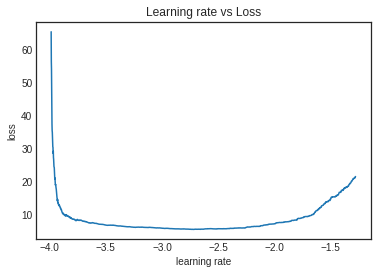

In [ ]:
lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

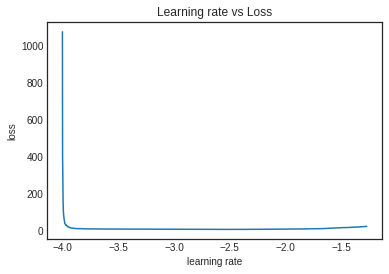

In [ ]:
lr_finder.plot_schedule()

In [ ]:
pow(10,-3.5) #0.000 001

0.00031622776601683794

In [ ]:
scores = model.evaluate(X_test, to_categorical(y_test, num_classes=6), batch_size=bs)
for score, metric_name in zip(scores, model.metrics_names):
    print("%s : %0.4f" % (metric_name, score))

882/882 [==============================] - 10s 10ms/step - loss: 153.4040 - get_f1: 0.5136
loss : 153.4040
get_f1 : 0.5136


## Find optimal learning rate - do=0.2 - NEW TRAINING DATA

In [ ]:
# bez danych walidacyjnych:
with tf.device("/device:GPU:0"):
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
input_shape

(224, 374, 3)

In [ ]:
bs=32

In [ ]:
lr_finder = LRFinder(X_train.shape[0], bs, minimum_lr=1e-4, maximum_lr=0.1,
                     lr_scale='exp',
                     # validation_data=(X_test, y_test),  # use the validation data for losses
                     validation_sample_rate=5,
                     verbose=True)

In [ ]:
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(6, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=[get_f1])

In [ ]:
with tf.device("/device:GPU:0"):
  #history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=1, batch_size=bs, validation_data=(X_test, to_categorical(y_test, num_classes=6)), callbacks=[lr_finder])
  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=1, batch_size=bs, callbacks=[lr_finder])


 - LRFinder: lr = 0.00011140 
65/65 [==============================] - 31s 102ms/step - loss: 4.9877 - get_f1: 0.4628


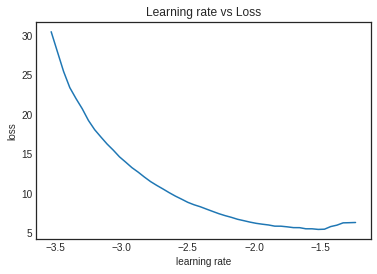

In [ ]:
lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

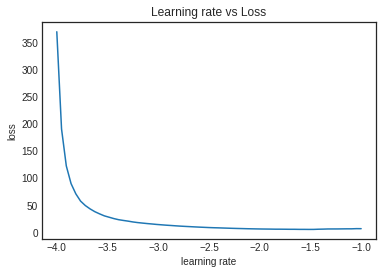

In [ ]:
lr_finder.plot_schedule()

In [ ]:
pow(10,-2) #0.000 001

0.01

In [ ]:
scores = model.evaluate(X_test, to_categorical(y_test, num_classes=6), batch_size=bs)
for score, metric_name in zip(scores, model.metrics_names):
    print("%s : %0.4f" % (metric_name, score))

28/28 [==============================] - 5s 116ms/step - loss: 7.6619 - get_f1: 0.7664
loss : 7.6619
get_f1 : 0.7664


## lr=0.01 & bs=1

In [ ]:
learning_rate = 0.01
batch_size = 1

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_15 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_15 (Dropout)        (None, 1280)              0         
                                                                 
 dense_15 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=10, batch_size=batch_size, validation_data=(X_val, to_categorical(y_val, num_classes=6)))

Epoch 1/10
1762/1762 [==============================] - 30s 15ms/step - loss: 24.9768 - get_f1: 0.6005 - val_loss: 12.4497 - val_get_f1: 0.7585
Epoch 2/10
1762/1762 [==============================] - 24s 14ms/step - loss: 29.9705 - get_f1: 0.6759 - val_loss: 13.9025 - val_get_f1: 0.8129
Epoch 3/10
1762/1762 [==============================] - 25s 14ms/step - loss: 32.0483 - get_f1: 0.7060 - val_loss: 17.7067 - val_get_f1: 0.7959
Epoch 4/10
1762/1762 [==============================] - 27s 15ms/step - loss: 31.6083 - get_f1: 0.7401 - val_loss: 16.9262 - val_get_f1: 0.8316
Epoch 5/10
1762/1762 [==============================] - 26s 15ms/step - loss: 33.9174 - get_f1: 0.7503 - val_loss: 18.9255 - val_get_f1: 0.8248
Epoch 6/10
1762/1762 [==============================] - 24s 14ms/step - loss: 38.6680 - get_f1: 0.7225 - val_loss: 30.3314 - val_get_f1: 0.7670
Epoch 7/10
1762/1762 [==============================] - 24s 14ms/step - loss: 36.0755 - get_f1: 0.7531 - val_loss: 20.8414 - val_get_f1:

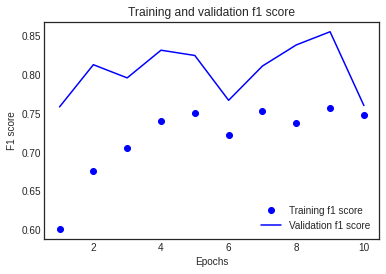

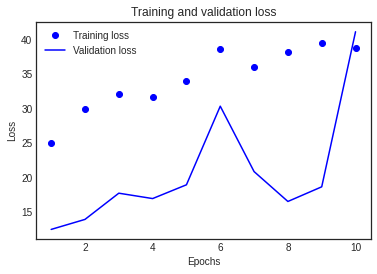

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y) 
# test_size=0.2?

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_16 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_16 (Dropout)        (None, 1280)              0         
                                                                 
 dense_16 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=1, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

2350/2350 [==============================] - 31s 11ms/step - loss: 25.1554 - get_f1: 0.6319
Training time: 46.983989000320435s.


In [ ]:
y_proba = model.predict(X_test, batch_size=batch_size)
y_pred = argmax(y_proba, axis=1).numpy()
accuracy_score(y_test, y_pred)

0.7891156462585034

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, to_categorical(y_train, num_classes=6), batch_size=batch_size))
  print('test: ', model.evaluate(X_test, to_categorical(y_test, num_classes=6), batch_size=batch_size))

2350/2350 [==============================] - 27s 11ms/step - loss: 15.4064 - get_f1: 0.7723
train:  [15.406411170959473, 0.7723403573036194]
588/588 [==============================] - 6s 10ms/step - loss: 14.2746 - get_f1: 0.7891
test:  [14.274616241455078, 0.7891156077384949]


In [ ]:
print_metrics(y_test, y_pred, y_proba)

f1 micro:  0.7891156462585034
f1 macro:  0.775452335142404
precision micro:  0.7891156462585034
precision macro:  0.805529205077382
recall micro:  0.7891156462585034
recall macro:  0.7865426937322647
accuracy:  0.7891156462585034
log_loss:  6.199966432249979


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.64      0.76       130
           1       0.82      0.57      0.68        47
           2       0.62      0.93      0.75       122
           3       0.63      0.98      0.77        47
           4       0.84      0.73      0.78       112
           5       0.99      0.87      0.93       130

    accuracy                           0.79       588
   macro avg       0.81      0.79      0.78       588
weighted avg       0.83      0.79      0.79       588



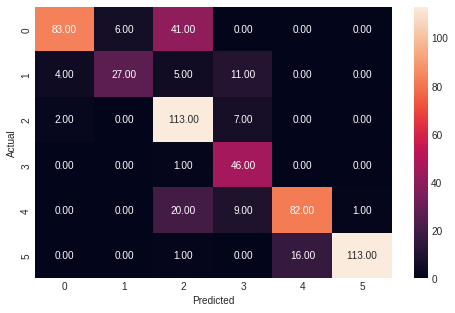

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.001 & bs=1

In [ ]:
learning_rate = 0.001
batch_size = 1

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_8 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_8 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=10, batch_size=batch_size, validation_data=(X_val, to_categorical(y_val, num_classes=6)))

Epoch 1/10
1762/1762 [==============================] - 32s 16ms/step - loss: 4.1379 - get_f1: 0.5817 - val_loss: 1.2200 - val_get_f1: 0.8214
Epoch 2/10
1762/1762 [==============================] - 26s 15ms/step - loss: 3.5088 - get_f1: 0.6907 - val_loss: 1.5407 - val_get_f1: 0.8299
Epoch 3/10
1762/1762 [==============================] - 27s 16ms/step - loss: 3.2002 - get_f1: 0.7225 - val_loss: 2.7202 - val_get_f1: 0.7500
Epoch 4/10
1762/1762 [==============================] - 25s 14ms/step - loss: 3.5941 - get_f1: 0.7299 - val_loss: 1.7916 - val_get_f1: 0.8333
Epoch 5/10
1762/1762 [==============================] - 25s 14ms/step - loss: 3.5764 - get_f1: 0.7452 - val_loss: 1.3665 - val_get_f1: 0.8588
Epoch 6/10
1762/1762 [==============================] - 25s 14ms/step - loss: 3.8923 - get_f1: 0.7372 - val_loss: 3.2847 - val_get_f1: 0.7755
Epoch 7/10
1762/1762 [==============================] - 33s 19ms/step - loss: 3.5107 - get_f1: 0.7531 - val_loss: 2.3130 - val_get_f1: 0.8027
Epoch 

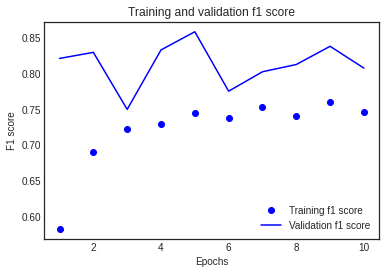

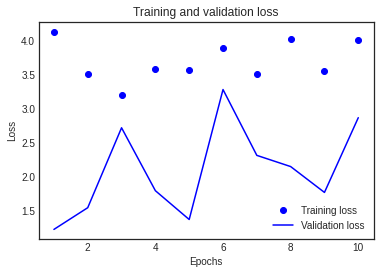

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y) 
# test_size=0.2?

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_9 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_9 (Dropout)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=5, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/5
2350/2350 [==============================] - 32s 12ms/step - loss: 3.9953 - get_f1: 0.6064
Epoch 2/5
2350/2350 [==============================] - 28s 12ms/step - loss: 3.1983 - get_f1: 0.7149
Epoch 3/5
2350/2350 [==============================] - 28s 12ms/step - loss: 3.3861 - get_f1: 0.7323
Epoch 4/5
2350/2350 [==============================] - 26s 11ms/step - loss: 3.6024 - get_f1: 0.7417
Epoch 5/5
2350/2350 [==============================] - 28s 12ms/step - loss: 3.6336 - get_f1: 0.7438
Training time: 147.08092045783997s.


In [ ]:
y_proba = model.predict(X_test, batch_size=batch_size)
y_pred = argmax(y_proba, axis=1).numpy()
accuracy_score(y_test, y_pred)

0.7789115646258503

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, to_categorical(y_train, num_classes=6), batch_size=batch_size))
  print('test: ', model.evaluate(X_test, to_categorical(y_test, num_classes=6), batch_size=batch_size))

2350/2350 [==============================] - 31s 12ms/step - loss: 2.0762 - get_f1: 0.8072
train:  [2.07624888420105, 0.807233989238739]
588/588 [==============================] - 6s 11ms/step - loss: 2.2933 - get_f1: 0.7789
test:  [2.2933292388916016, 0.7789115309715271]


In [ ]:
print_metrics(y_test, y_pred, y_proba)

f1 micro:  0.7789115646258504
f1 macro:  0.7583537558102038
precision micro:  0.7789115646258503
precision macro:  0.8239259199173289
recall micro:  0.7789115646258503
recall macro:  0.7767798131702038
accuracy:  0.7789115646258503
log_loss:  2.275728020734854


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.98      0.82       130
           1       0.82      0.79      0.80        47
           2       0.97      0.26      0.41       122
           3       0.84      0.77      0.80        47
           4       0.65      0.94      0.77       112
           5       0.95      0.93      0.94       130

    accuracy                           0.78       588
   macro avg       0.82      0.78      0.76       588
weighted avg       0.83      0.78      0.75       588



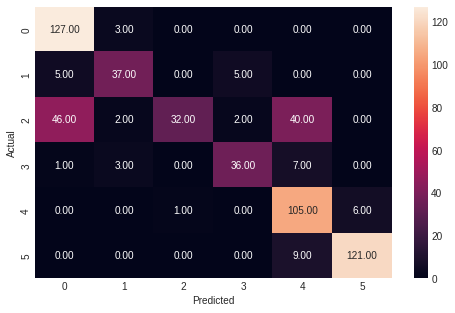

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.001 & bs=16

In [ ]:
learning_rate = 0.001
batch_size = 16

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_17 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_17 (Dropout)        (None, 1280)              0         
                                                                 
 dense_17 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=10, batch_size=batch_size, validation_data=(X_val, to_categorical(y_val, num_classes=6)))

Epoch 1/10
111/111 [==============================] - 16s 88ms/step - loss: 4.5260 - get_f1: 0.4526 - val_loss: 0.8126 - val_get_f1: 0.7893
Epoch 2/10
111/111 [==============================] - 8s 69ms/step - loss: 2.5435 - get_f1: 0.6418 - val_loss: 0.7765 - val_get_f1: 0.8203
Epoch 3/10
111/111 [==============================] - 8s 69ms/step - loss: 2.2297 - get_f1: 0.6864 - val_loss: 0.6588 - val_get_f1: 0.8473
Epoch 4/10
111/111 [==============================] - 8s 69ms/step - loss: 1.9998 - get_f1: 0.7086 - val_loss: 0.9704 - val_get_f1: 0.8195
Epoch 5/10
111/111 [==============================] - 8s 69ms/step - loss: 1.6957 - get_f1: 0.7362 - val_loss: 1.3025 - val_get_f1: 0.8053
Epoch 6/10
111/111 [==============================] - 8s 69ms/step - loss: 1.6212 - get_f1: 0.7459 - val_loss: 0.8808 - val_get_f1: 0.8341
Epoch 7/10
111/111 [==============================] - 8s 70ms/step - loss: 1.6226 - get_f1: 0.7361 - val_loss: 0.7155 - val_get_f1: 0.8588
Epoch 8/10
111/111 [======

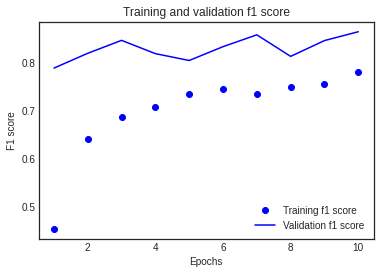

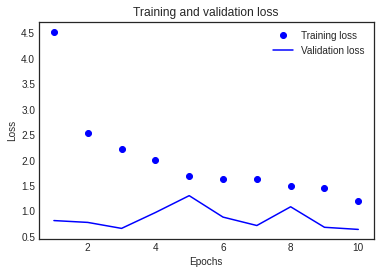

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y) 
# test_size=0.2?

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_18 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_18 (Dropout)        (None, 1280)              0         
                                                                 
 dense_18 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=3, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/3
147/147 [==============================] - 13s 54ms/step - loss: 4.1852 - get_f1: 0.4873
Epoch 2/3
147/147 [==============================] - 8s 54ms/step - loss: 2.2744 - get_f1: 0.6829
Epoch 3/3
147/147 [==============================] - 8s 54ms/step - loss: 1.8299 - get_f1: 0.7189
Training time: 46.61747980117798s.


In [ ]:
y_proba = model.predict(X_test, batch_size=batch_size)
y_pred = argmax(y_proba, axis=1).numpy()
accuracy_score(y_test, y_pred)

0.7636054421768708

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, to_categorical(y_train, num_classes=6), batch_size=batch_size))
  print('test: ', model.evaluate(X_test, to_categorical(y_test, num_classes=6), batch_size=batch_size))

147/147 [==============================] - 10s 53ms/step - loss: 1.2426 - get_f1: 0.7399
train:  [1.2425823211669922, 0.7398585677146912]
37/37 [==============================] - 2s 57ms/step - loss: 1.0910 - get_f1: 0.7641
test:  [1.0909628868103027, 0.7640765309333801]


In [ ]:
print_metrics(y_test, y_pred, y_proba)

f1 micro:  0.7636054421768708
f1 macro:  0.7639048271867827
precision micro:  0.7636054421768708
precision macro:  0.8280158892949786
recall micro:  0.7636054421768708
recall macro:  0.7608905765493662
accuracy:  0.7636054421768708
log_loss:  1.0909626476206469


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.43      0.60       130
           1       0.82      0.70      0.76        47
           2       0.56      0.90      0.69       122
           3       0.85      0.74      0.80        47
           4       0.74      0.96      0.84       112
           5       0.99      0.83      0.90       130

    accuracy                           0.76       588
   macro avg       0.83      0.76      0.76       588
weighted avg       0.83      0.76      0.76       588



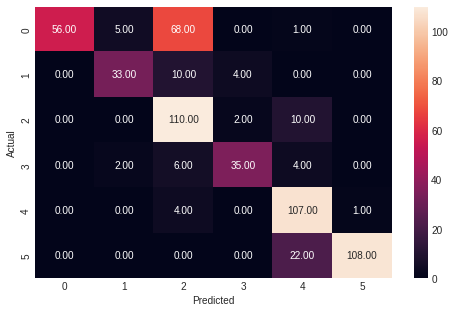

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.001 & DO=0.2 & bs=16

In [ ]:
learning_rate = 0.001
batch_size = 16

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_9 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_9 (Dropout)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=10, batch_size=batch_size, validation_data=(X_val, to_categorical(y_val, num_classes=6)))

Epoch 1/10
111/111 [==============================] - 15s 81ms/step - loss: 2.3539 - get_f1: 0.5443 - val_loss: 0.6964 - val_get_f1: 0.8187
Epoch 2/10
111/111 [==============================] - 8s 68ms/step - loss: 1.2417 - get_f1: 0.7247 - val_loss: 0.5551 - val_get_f1: 0.8194
Epoch 3/10
111/111 [==============================] - 8s 68ms/step - loss: 1.1754 - get_f1: 0.7456 - val_loss: 0.7423 - val_get_f1: 0.8314
Epoch 4/10
111/111 [==============================] - 8s 68ms/step - loss: 0.8702 - get_f1: 0.8006 - val_loss: 0.5103 - val_get_f1: 0.8699
Epoch 5/10
111/111 [==============================] - 8s 69ms/step - loss: 0.9377 - get_f1: 0.7740 - val_loss: 0.7218 - val_get_f1: 0.8253
Epoch 6/10
111/111 [==============================] - 8s 68ms/step - loss: 0.9652 - get_f1: 0.7986 - val_loss: 0.7229 - val_get_f1: 0.8159
Epoch 7/10
111/111 [==============================] - 8s 68ms/step - loss: 0.9595 - get_f1: 0.7981 - val_loss: 0.7493 - val_get_f1: 0.8366
Epoch 8/10
111/111 [======

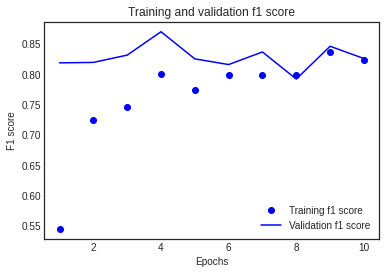

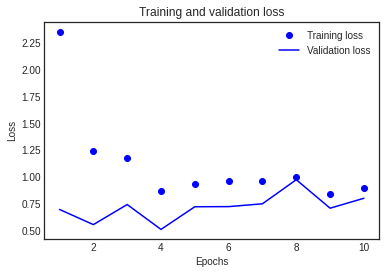

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y) 
# test_size=0.2?

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_10 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_10 (Dropout)        (None, 1280)              0         
                                                                 
 dense_10 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=4, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/4
147/147 [==============================] - 14s 53ms/step - loss: 2.0851 - get_f1: 0.5942
Epoch 2/4
147/147 [==============================] - 8s 53ms/step - loss: 1.3276 - get_f1: 0.7400
Epoch 3/4
147/147 [==============================] - 8s 53ms/step - loss: 1.1301 - get_f1: 0.7800
Epoch 4/4
147/147 [==============================] - 8s 52ms/step - loss: 1.0053 - get_f1: 0.7929
Training time: 47.48931312561035s.


In [ ]:
y_proba = model.predict(X_test, batch_size=batch_size)
y_pred = argmax(y_proba, axis=1).numpy()
accuracy_score(y_test, y_pred)

0.7993197278911565

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, to_categorical(y_train, num_classes=6), batch_size=batch_size))
  print('test: ', model.evaluate(X_test, to_categorical(y_test, num_classes=6), batch_size=batch_size))

147/147 [==============================] - 9s 52ms/step - loss: 0.7718 - get_f1: 0.8242
train:  [0.7717863321304321, 0.8241927027702332]
37/37 [==============================] - 2s 52ms/step - loss: 0.9508 - get_f1: 0.7964
test:  [0.9508427381515503, 0.796352744102478]


In [ ]:
print_metrics(y_test, y_pred, y_proba)

f1 micro:  0.7993197278911565
f1 macro:  0.7487770331520331
precision micro:  0.7993197278911565
precision macro:  0.8458690410896293
recall micro:  0.7993197278911565
recall macro:  0.7252940336607933
accuracy:  0.7993197278911565
log_loss:  0.9508426259168216


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.75      0.84       130
           1       0.82      0.57      0.68        47
           2       0.57      0.97      0.72       122
           3       0.88      0.32      0.47        47
           4       0.90      0.77      0.83       112
           5       0.97      0.97      0.97       130

    accuracy                           0.80       588
   macro avg       0.85      0.73      0.75       588
weighted avg       0.85      0.80      0.80       588



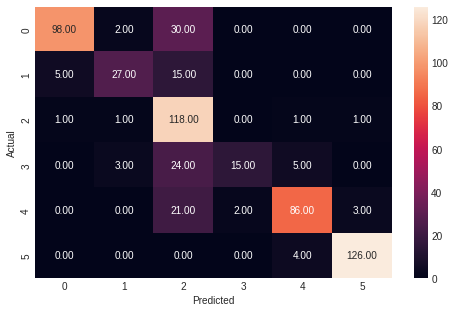

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.0001

In [ ]:
learning_rate = 0.0001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_11 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_11 (Dropout)        (None, 1280)              0         
                                                                 
 dense_11 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=20, batch_size=batch_size, validation_data=(X_val, to_categorical(y_val, num_classes=6)))

Epoch 1/20
56/56 [==============================] - 14s 150ms/step - loss: 8.2841 - get_f1: 0.1996 - val_loss: 2.5011 - val_get_f1: 0.3858
Epoch 2/20
56/56 [==============================] - 7s 123ms/step - loss: 6.5872 - get_f1: 0.2686 - val_loss: 1.7427 - val_get_f1: 0.5692
Epoch 3/20
56/56 [==============================] - 7s 123ms/step - loss: 5.7713 - get_f1: 0.3151 - val_loss: 1.1808 - val_get_f1: 0.6624
Epoch 4/20
56/56 [==============================] - 7s 123ms/step - loss: 4.9057 - get_f1: 0.3770 - val_loss: 0.9478 - val_get_f1: 0.7146
Epoch 5/20
56/56 [==============================] - 7s 123ms/step - loss: 4.3598 - get_f1: 0.4114 - val_loss: 0.8085 - val_get_f1: 0.7332
Epoch 6/20
56/56 [==============================] - 7s 124ms/step - loss: 3.9324 - get_f1: 0.4473 - val_loss: 0.7453 - val_get_f1: 0.7695
Epoch 7/20
56/56 [==============================] - 7s 124ms/step - loss: 3.5938 - get_f1: 0.4740 - val_loss: 0.6337 - val_get_f1: 0.7959
Epoch 8/20
56/56 [===============

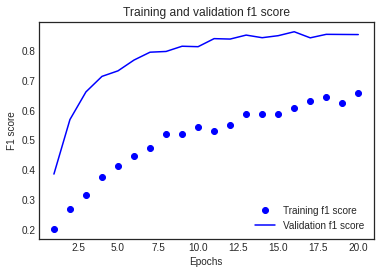

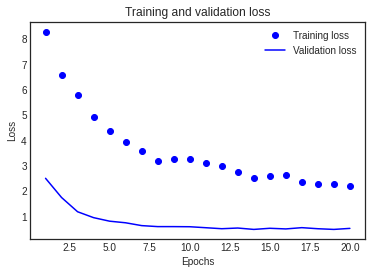

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y) 
# test_size=0.2?

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_12 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_12 (Dropout)        (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=16, batch_size=batch_size) # LEPSZE EPOCHS=15

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/16
74/74 [==============================] - 15s 95ms/step - loss: 7.8870 - get_f1: 0.2026
Epoch 2/16
74/74 [==============================] - 7s 94ms/step - loss: 6.0639 - get_f1: 0.2906
Epoch 3/16
74/74 [==============================] - 7s 95ms/step - loss: 5.2156 - get_f1: 0.3503
Epoch 4/16
74/74 [==============================] - 7s 95ms/step - loss: 4.2638 - get_f1: 0.4271
Epoch 5/16
74/74 [==============================] - 7s 95ms/step - loss: 3.7446 - get_f1: 0.4607
Epoch 6/16
74/74 [==============================] - 7s 95ms/step - loss: 3.3946 - get_f1: 0.5143
Epoch 7/16
74/74 [==============================] - 7s 95ms/step - loss: 3.0395 - get_f1: 0.5375
Epoch 8/16
74/74 [==============================] - 7s 95ms/step - loss: 2.9055 - get_f1: 0.5593
Epoch 9/16
74/74 [==============================] - 7s 96ms/step - loss: 2.6691 - get_f1: 0.5678
Epoch 10/16
74/74 [==============================] - 7s 95ms/step - loss: 2.5866 - get_f1: 0.5819
Epoch 11/16
74/74 [=========

In [ ]:
y_proba = model.predict(X_test)
y_pred = argmax(y_proba, axis=1).numpy()
accuracy_score(y_test, y_pred)

0.8537414965986394

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, to_categorical(y_train, num_classes=6)))
  print('test: ', model.evaluate(X_test, to_categorical(y_test, num_classes=6)))

74/74 [==============================] - 8s 95ms/step - loss: 0.5423 - get_f1: 0.8523
train:  [0.5422596335411072, 0.8523332476615906]
19/19 [==============================] - 2s 91ms/step - loss: 0.5445 - get_f1: 0.8446
test:  [0.5445173382759094, 0.8445593118667603]


In [ ]:
print_metrics(y_test, y_pred, y_proba)

f1 micro:  0.8537414965986394
f1 macro:  0.8298744730927293
precision micro:  0.8537414965986394
precision macro:  0.8399669774669775
recall micro:  0.8537414965986394
recall macro:  0.8254478299865463
accuracy:  0.8537414965986394
log_loss:  0.5445174408569996


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.89       130
           1       0.75      0.70      0.73        47
           2       0.79      0.85      0.82       122
           3       0.80      0.77      0.78        47
           4       0.93      0.73      0.82       112
           5       0.90      0.98      0.94       130

    accuracy                           0.85       588
   macro avg       0.84      0.83      0.83       588
weighted avg       0.86      0.85      0.85       588



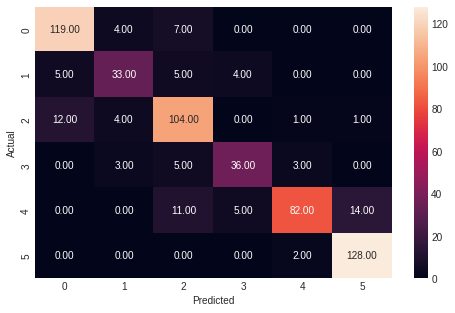

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.0003

In [ ]:
learning_rate = 0.0003
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_13 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_13 (Dropout)        (None, 1280)              0         
                                                                 
 dense_13 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=10, batch_size=batch_size, validation_data=(X_val, to_categorical(y_val, num_classes=6)))

Epoch 1/10
56/56 [==============================] - 14s 154ms/step - loss: 6.7722 - get_f1: 0.2655 - val_loss: 1.2973 - val_get_f1: 0.6218
Epoch 2/10
56/56 [==============================] - 7s 128ms/step - loss: 4.4989 - get_f1: 0.4026 - val_loss: 0.8560 - val_get_f1: 0.7435
Epoch 3/10
56/56 [==============================] - 7s 128ms/step - loss: 3.3410 - get_f1: 0.5097 - val_loss: 0.7725 - val_get_f1: 0.7811
Epoch 4/10
56/56 [==============================] - 8s 144ms/step - loss: 2.7981 - get_f1: 0.5642 - val_loss: 0.7407 - val_get_f1: 0.7902
Epoch 5/10
56/56 [==============================] - 8s 146ms/step - loss: 2.6192 - get_f1: 0.6074 - val_loss: 0.7642 - val_get_f1: 0.7992
Epoch 6/10
56/56 [==============================] - 7s 131ms/step - loss: 2.5245 - get_f1: 0.6134 - val_loss: 0.8352 - val_get_f1: 0.8087
Epoch 7/10
56/56 [==============================] - 7s 129ms/step - loss: 2.3392 - get_f1: 0.6520 - val_loss: 0.8212 - val_get_f1: 0.7966
Epoch 8/10
56/56 [===============

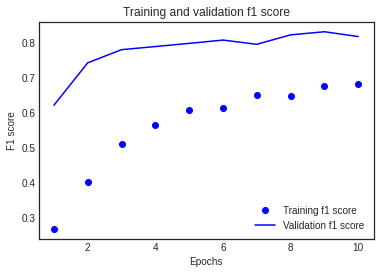

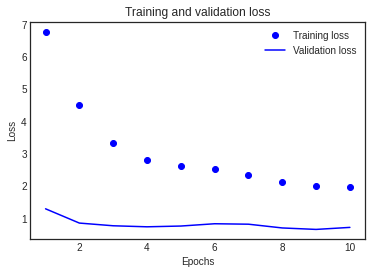

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y) 
# test_size=0.2?

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_14 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_14 (Dropout)        (None, 1280)              0         
                                                                 
 dense_14 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=4, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/4
74/74 [==============================] - 13s 98ms/step - loss: 5.8112 - get_f1: 0.3242
Epoch 2/4
74/74 [==============================] - 7s 100ms/step - loss: 3.5011 - get_f1: 0.5148
Epoch 3/4
74/74 [==============================] - 7s 99ms/step - loss: 2.9502 - get_f1: 0.5698
Epoch 4/4
74/74 [==============================] - 7s 100ms/step - loss: 2.3095 - get_f1: 0.6196
Training time: 46.946908712387085s.


In [ ]:
y_proba = model.predict(X_test)
y_pred = argmax(y_proba, axis=1).numpy()
accuracy_score(y_test, y_pred)

0.8503401360544217

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, to_categorical(y_train, num_classes=6)))
  print('test: ', model.evaluate(X_test, to_categorical(y_test, num_classes=6)))

74/74 [==============================] - 9s 97ms/step - loss: 0.5256 - get_f1: 0.8558
train:  [0.5255511403083801, 0.8557549118995667]
19/19 [==============================] - 2s 96ms/step - loss: 0.5330 - get_f1: 0.8494
test:  [0.5329944491386414, 0.8493847846984863]


In [ ]:
print_metrics(y_test, y_pred, y_proba)

f1 micro:  0.8503401360544217
f1 macro:  0.8336284487539053
precision micro:  0.8503401360544217
precision macro:  0.843109167535986
recall micro:  0.8503401360544217
recall macro:  0.8263296195433446
accuracy:  0.8503401360544217
log_loss:  0.5329944746482445


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       130
           1       0.81      0.72      0.76        47
           2       0.82      0.79      0.80       122
           3       0.84      0.77      0.80        47
           4       0.83      0.81      0.82       112
           5       0.92      0.95      0.94       130

    accuracy                           0.85       588
   macro avg       0.84      0.83      0.83       588
weighted avg       0.85      0.85      0.85       588



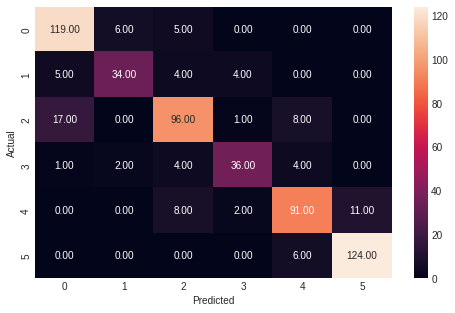

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.001 & do=0.2 - SELECTED

In [ ]:
learning_rate = 0.001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_4 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=10, batch_size=batch_size, validation_data=(X_val, to_categorical(y_val, num_classes=6)))

Epoch 1/10
56/56 [==============================] - 14s 151ms/step - loss: 2.8921 - get_f1: 0.5104 - val_loss: 0.9179 - val_get_f1: 0.7801
Epoch 2/10
56/56 [==============================] - 7s 125ms/step - loss: 1.2740 - get_f1: 0.7061 - val_loss: 0.7593 - val_get_f1: 0.8390
Epoch 3/10
56/56 [==============================] - 7s 126ms/step - loss: 1.0851 - get_f1: 0.7443 - val_loss: 0.4835 - val_get_f1: 0.8477
Epoch 4/10
56/56 [==============================] - 7s 125ms/step - loss: 0.9845 - get_f1: 0.7655 - val_loss: 0.8107 - val_get_f1: 0.7825
Epoch 5/10
56/56 [==============================] - 7s 125ms/step - loss: 1.0732 - get_f1: 0.7481 - val_loss: 1.1489 - val_get_f1: 0.7725
Epoch 6/10
56/56 [==============================] - 7s 125ms/step - loss: 1.3027 - get_f1: 0.7537 - val_loss: 0.8393 - val_get_f1: 0.8107
Epoch 7/10
56/56 [==============================] - 7s 125ms/step - loss: 0.9335 - get_f1: 0.7978 - val_loss: 0.5351 - val_get_f1: 0.8689
Epoch 8/10
56/56 [===============

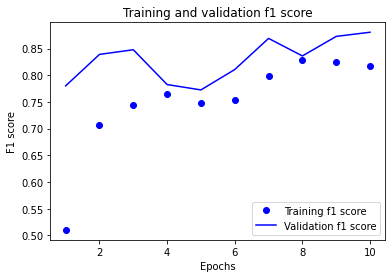

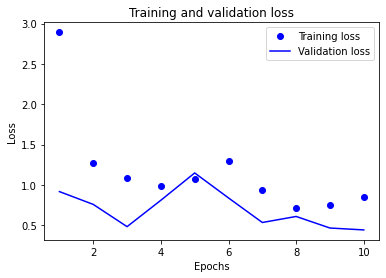

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y) 
# test_size=0.2?

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=3, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/3
74/74 [==============================] - 16s 102ms/step - loss: 1.9533 - get_f1: 0.6042
Epoch 2/3
74/74 [==============================] - 7s 95ms/step - loss: 1.1603 - get_f1: 0.7350
Epoch 3/3
74/74 [==============================] - 7s 94ms/step - loss: 0.9939 - get_f1: 0.7666
Training time: 47.39358997344971s.


In [ ]:
y_proba = model.predict(X_test)
y_pred = argmax(y_proba, axis=1).numpy()
accuracy_score(y_test, y_pred)

0.8758503401360545

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, to_categorical(y_train, num_classes=6)))
  print('test: ', model.evaluate(X_test, to_categorical(y_test, num_classes=6)))

74/74 [==============================] - 8s 92ms/step - loss: 0.3772 - get_f1: 0.8788
train:  [0.3772135376930237, 0.8788197636604309]
19/19 [==============================] - 2s 90ms/step - loss: 0.4429 - get_f1: 0.8763
test:  [0.4428788721561432, 0.8763314485549927]


In [ ]:
print_metrics(y_test, y_pred, y_proba)

f1 micro:  0.8758503401360545
f1 macro:  0.8555770879510415
precision micro:  0.8758503401360545
precision macro:  0.8569278504110751
recall micro:  0.8758503401360545
recall macro:  0.8584696818412375
accuracy:  0.8758503401360545
log_loss:  0.44287885787412157


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       130
           1       0.81      0.74      0.78        47
           2       0.83      0.90      0.86       122
           3       0.73      0.85      0.78        47
           4       0.92      0.83      0.87       112
           5       0.92      0.97      0.94       130

    accuracy                           0.88       588
   macro avg       0.86      0.86      0.86       588
weighted avg       0.88      0.88      0.88       588



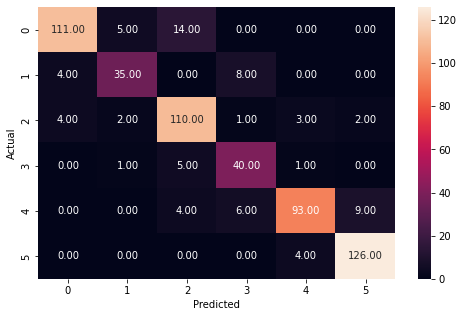

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
model.save('drive/MyDrive/mgr/saved_models/3m_ef0_structures')

In [ ]:
test_model = models.load_model('drive/MyDrive/mgr/saved_models/3m_ef0_structures', custom_objects={"get_f1": get_f1})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y) 

In [ ]:
y_proba = test_model.predict(X_test)
y_pred = argmax(y_proba, axis=1).numpy()

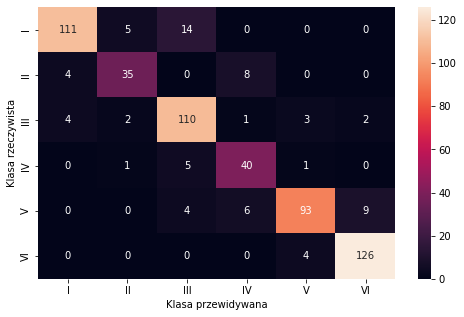

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.0f')
ax.xaxis.set_ticklabels(['I', 'II', 'III', 'IV', 'V', 'VI'])
ax.yaxis.set_ticklabels(['I', 'II', 'III', 'IV', 'V', 'VI']);
plt.ylabel('Klasa rzeczywista')
plt.xlabel('Klasa przewidywana')
plt.show(block=False)

In [ ]:
print(classification_report(y_test, argmax(test_model.predict(X_test), axis=1).numpy())) 

## lr=0.001 

In [ ]:
learning_rate = 0.001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_13 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_13 (Dropout)        (None, 1280)              0         
                                                                 
 dense_13 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=10, batch_size=batch_size, validation_data=(X_val, to_categorical(y_val, num_classes=6)))

Epoch 1/10
56/56 [==============================] - 14s 149ms/step - loss: 4.8355 - get_f1: 0.4112 - val_loss: 0.9792 - val_get_f1: 0.7796
Epoch 2/10
56/56 [==============================] - 7s 123ms/step - loss: 2.3609 - get_f1: 0.6404 - val_loss: 0.5618 - val_get_f1: 0.8291
Epoch 3/10
56/56 [==============================] - 7s 123ms/step - loss: 2.2533 - get_f1: 0.6790 - val_loss: 0.6084 - val_get_f1: 0.8604
Epoch 4/10
56/56 [==============================] - 7s 124ms/step - loss: 1.9012 - get_f1: 0.6893 - val_loss: 0.6947 - val_get_f1: 0.8317
Epoch 5/10
56/56 [==============================] - 7s 124ms/step - loss: 1.8127 - get_f1: 0.7232 - val_loss: 0.5105 - val_get_f1: 0.8759
Epoch 6/10
56/56 [==============================] - 7s 124ms/step - loss: 1.6323 - get_f1: 0.7383 - val_loss: 0.5737 - val_get_f1: 0.8698
Epoch 7/10
56/56 [==============================] - 7s 124ms/step - loss: 1.3806 - get_f1: 0.7649 - val_loss: 0.6513 - val_get_f1: 0.8549
Epoch 8/10
56/56 [===============

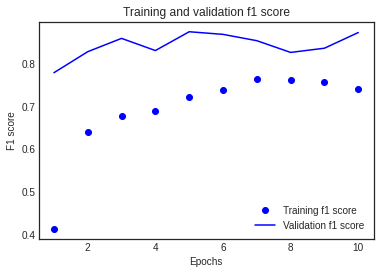

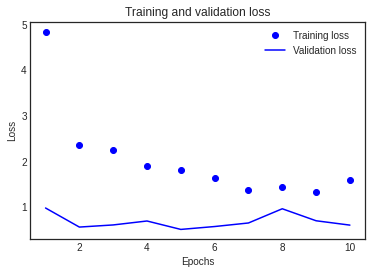

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y) 
# test_size=0.2?

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=3, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/3
74/74 [==============================] - 16s 101ms/step - loss: 4.7792 - get_f1: 0.4480
Epoch 2/3
74/74 [==============================] - 7s 94ms/step - loss: 2.2798 - get_f1: 0.6426
Epoch 3/3
74/74 [==============================] - 7s 94ms/step - loss: 2.0295 - get_f1: 0.6934
Training time: 47.362351179122925s.


In [ ]:
y_proba = model.predict(X_test)
y_pred = argmax(y_proba, axis=1).numpy()
accuracy_score(y_test, y_pred)

0.79421768707483

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, to_categorical(y_train, num_classes=6)))
  print('test: ', model.evaluate(X_test, to_categorical(y_test, num_classes=6)))

74/74 [==============================] - 8s 93ms/step - loss: 0.8746 - get_f1: 0.8209
train:  [0.8745863437652588, 0.8208572864532471]
19/19 [==============================] - 2s 92ms/step - loss: 0.9381 - get_f1: 0.7897
test:  [0.9380960464477539, 0.7897086143493652]


In [ ]:
print_metrics(y_test, y_pred, y_proba)

f1 micro:  0.79421768707483
f1 macro:  0.772668782528373
precision micro:  0.79421768707483
precision macro:  0.8097288016329477
recall micro:  0.79421768707483
recall macro:  0.7695896432947357
accuracy:  0.79421768707483
log_loss:  0.9380960809658686


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.97      0.85       130
           1       0.85      0.62      0.72        47
           2       0.68      0.70      0.69       122
           3       0.75      0.81      0.78        47
           4       0.95      0.52      0.67       112
           5       0.87      1.00      0.93       130

    accuracy                           0.79       588
   macro avg       0.81      0.77      0.77       588
weighted avg       0.81      0.79      0.78       588



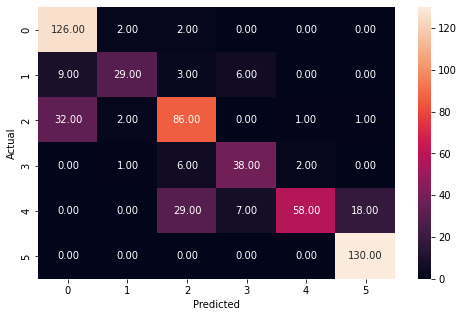

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.01 

In [ ]:
learning_rate = 0.01
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=10, batch_size=batch_size, validation_data=(X_val, to_categorical(y_val, num_classes=6)))

Epoch 1/10
56/56 [==============================] - 16s 170ms/step - loss: 6.7496 - get_f1: 0.6062 - val_loss: 4.6924 - val_get_f1: 0.6897
Epoch 2/10
56/56 [==============================] - 7s 126ms/step - loss: 3.9676 - get_f1: 0.7115 - val_loss: 6.5890 - val_get_f1: 0.6924
Epoch 3/10
56/56 [==============================] - 7s 127ms/step - loss: 5.0136 - get_f1: 0.7169 - val_loss: 5.7880 - val_get_f1: 0.7116
Epoch 4/10
56/56 [==============================] - 7s 126ms/step - loss: 7.1000 - get_f1: 0.6953 - val_loss: 2.3560 - val_get_f1: 0.8300
Epoch 5/10
56/56 [==============================] - 7s 129ms/step - loss: 4.8814 - get_f1: 0.7374 - val_loss: 4.2883 - val_get_f1: 0.7664
Epoch 6/10
56/56 [==============================] - 7s 128ms/step - loss: 6.1892 - get_f1: 0.7362 - val_loss: 5.2128 - val_get_f1: 0.7796
Epoch 7/10
56/56 [==============================] - 7s 128ms/step - loss: 5.2504 - get_f1: 0.7575 - val_loss: 4.0557 - val_get_f1: 0.8015
Epoch 8/10
56/56 [===============

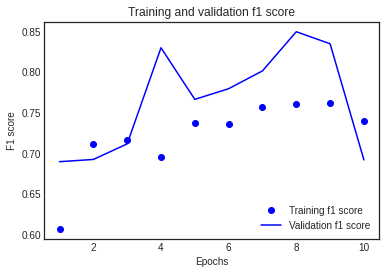

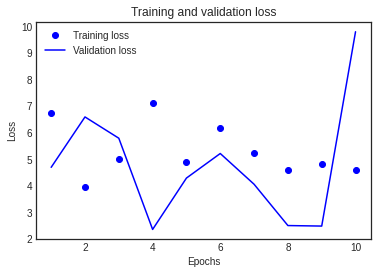

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y) 
# test_size=0.2?

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_2 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=4, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/4
74/74 [==============================] - 13s 106ms/step - loss: 6.8714 - get_f1: 0.6207
Epoch 2/4
74/74 [==============================] - 7s 98ms/step - loss: 3.2356 - get_f1: 0.7507
Epoch 3/4
74/74 [==============================] - 7s 100ms/step - loss: 3.8445 - get_f1: 0.7409
Epoch 4/4
74/74 [==============================] - 7s 98ms/step - loss: 5.4816 - get_f1: 0.7128
Training time: 46.5918288230896s.


In [ ]:
y_proba = model.predict(X_test)
y_pred = argmax(y_proba, axis=1).numpy()
accuracy_score(y_test, y_pred)

0.8656462585034014

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, to_categorical(y_train, num_classes=6)))
  print('test: ', model.evaluate(X_test, to_categorical(y_test, num_classes=6)))

74/74 [==============================] - 9s 97ms/step - loss: 1.5416 - get_f1: 0.8754
train:  [1.5416003465652466, 0.8753618597984314]
19/19 [==============================] - 2s 94ms/step - loss: 1.6862 - get_f1: 0.8680
test:  [1.6861976385116577, 0.8679771423339844]


In [ ]:
print_metrics(y_test, y_pred, y_proba)

ValueError: ignored

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       130
           1       0.78      0.81      0.79        47
           2       0.78      0.84      0.81       122
           3       0.90      0.79      0.84        47
           4       0.93      0.79      0.85       112
           5       0.95      0.98      0.96       130

    accuracy                           0.87       588
   macro avg       0.86      0.85      0.85       588
weighted avg       0.87      0.87      0.87       588



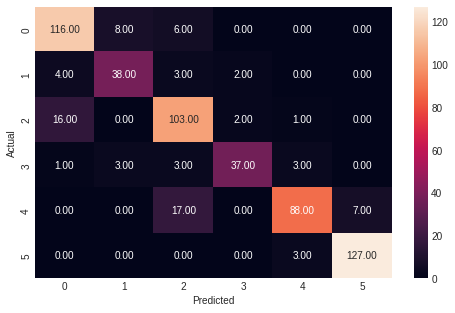

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.01 & do=0.2

In [ ]:
learning_rate = 0.01
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_7 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_7 (Dropout)         (None, 1280)              0         
                                                                 
 dense_7 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=10, batch_size=batch_size, validation_data=(X_val, to_categorical(y_val, num_classes=6)))

Epoch 1/10
56/56 [==============================] - 14s 162ms/step - loss: 8.1881 - get_f1: 0.6077 - val_loss: 2.0122 - val_get_f1: 0.7763
Epoch 2/10
56/56 [==============================] - 7s 123ms/step - loss: 2.4635 - get_f1: 0.7829 - val_loss: 1.0331 - val_get_f1: 0.8596
Epoch 3/10
56/56 [==============================] - 7s 123ms/step - loss: 2.0476 - get_f1: 0.7707 - val_loss: 7.2171 - val_get_f1: 0.6283
Epoch 4/10
56/56 [==============================] - 7s 123ms/step - loss: 4.3809 - get_f1: 0.7411 - val_loss: 4.8708 - val_get_f1: 0.7385
Epoch 5/10
56/56 [==============================] - 7s 124ms/step - loss: 2.5906 - get_f1: 0.8132 - val_loss: 2.8919 - val_get_f1: 0.8268
Epoch 6/10
56/56 [==============================] - 7s 124ms/step - loss: 3.3235 - get_f1: 0.7915 - val_loss: 4.8617 - val_get_f1: 0.7303
Epoch 7/10
56/56 [==============================] - 7s 124ms/step - loss: 3.2926 - get_f1: 0.7836 - val_loss: 9.9878 - val_get_f1: 0.4578
Epoch 8/10
56/56 [===============

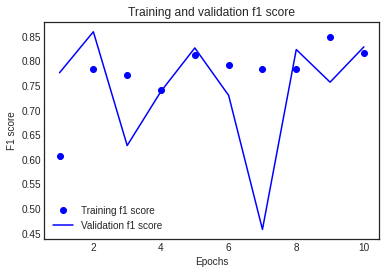

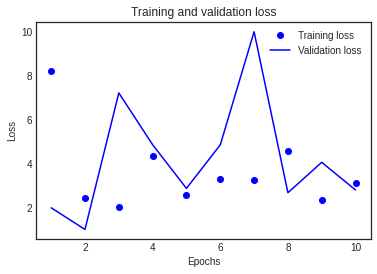

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y) 
# test_size=0.2?

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(6, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_8 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_8 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, to_categorical(y_train, num_classes=6), epochs=2, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/2
74/74 [==============================] - 13s 95ms/step - loss: 9.2947 - get_f1: 0.6498
Epoch 2/2
74/74 [==============================] - 7s 95ms/step - loss: 2.5266 - get_f1: 0.7749
Training time: 27.13187527656555s.


In [ ]:
y_proba = model.predict(X_test)
y_pred = argmax(y_proba, axis=1).numpy()
accuracy_score(y_test, y_pred)

0.8401360544217688

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, to_categorical(y_train, num_classes=6)))
  print('test: ', model.evaluate(X_test, to_categorical(y_test, num_classes=6)))

74/74 [==============================] - 8s 93ms/step - loss: 1.1031 - get_f1: 0.8556
train:  [1.1031041145324707, 0.8555804491043091]
19/19 [==============================] - 2s 91ms/step - loss: 1.6358 - get_f1: 0.8344
test:  [1.6358084678649902, 0.8344298005104065]


In [ ]:
print_metrics(y_test, y_pred, y_proba)

f1 micro:  0.8401360544217686
f1 macro:  0.8211080877957105
precision micro:  0.8401360544217688
precision macro:  0.8371355367108793
recall micro:  0.8401360544217688
recall macro:  0.8316627586748794
accuracy:  0.8401360544217688
log_loss:  1.565488030532331


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88       130
           1       0.63      0.94      0.75        47
           2       0.83      0.85      0.84       122
           3       0.86      0.64      0.73        47
           4       0.73      0.96      0.83       112
           5       1.00      0.80      0.89       130

    accuracy                           0.84       588
   macro avg       0.84      0.83      0.82       588
weighted avg       0.87      0.84      0.84       588



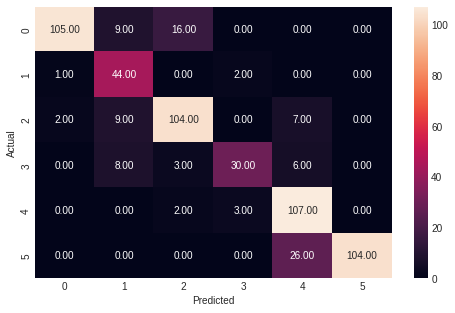

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Rm

## Load model for structure classification (EfficientNet-B0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y) 

In [ ]:
struct_model = models.load_model('drive/MyDrive/mgr/saved_models/3m_ef0_structures', custom_objects={"get_f1": get_f1})

In [ ]:
print(classification_report(y_test, argmax(struct_model.predict(X_test), axis=1).numpy())) 

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       130
           1       0.81      0.74      0.78        47
           2       0.83      0.90      0.86       122
           3       0.73      0.85      0.78        47
           4       0.92      0.83      0.87       112
           5       0.92      0.97      0.94       130

    accuracy                           0.88       588
   macro avg       0.86      0.86      0.86       588
weighted avg       0.88      0.88      0.88       588



## Load dictionary - {image_path : structures_list}

In [ ]:
## dict {image : list_of_subimages}
# load low_Rm & high_Rm
low_Rm_dict = open_dict(os.path.join(DATA_DIR, 'files_dict_low_Rm.pkl'))
high_Rm_dict = open_dict(os.path.join(DATA_DIR, 'files_dict_high_Rm.pkl'))

# Rm_dict = merge_dict(low_Rm_dict, high_Rm_dict)
#len(Rm_dict) #2914

In [ ]:
## dict {image : dict_of_subimages {subimage_name : matrix} }
# load low_Rm & high_Rm structures
struct_low_Rm_dict = open_dict(os.path.join(DATA_DIR, 'structures_dict_low_Rm.pkl'))
struct_high_Rm_dict = open_dict(os.path.join(DATA_DIR, 'structures_dict_high_Rm.pkl'))

#struct_Rm_dict = merge_dict(struct_low_Rm_dict, struct_high_Rm_dict)
#len(struct_Rm_dict)

## Classify structures

In [ ]:
def predict_structures(files_dict, images_dict):
  structures_count = {}

  for key, values in files_dict.items(): #
    structures_count[key] = [0, 0, 0, 0, 0, 0]

    for value in values:
      if value!='':
        val = value.split('/')[1]
        X_struct_matrix = images_dict[key][val] 
        X_struct_matrix = cv.cvtColor(X_struct_matrix,cv.COLOR_GRAY2BGR)
        #plt.figure()
        #plt.imshow(X_struct_matrix)
        
        X_struct_matrix = np.array([X_struct_matrix])
        y_pred_struct = argmax(struct_model.predict(X_struct_matrix), axis=1).numpy()[0]

        structures_count[key][y_pred_struct] += 1

  return structures_count

In [ ]:
# count structures low Rm
STRUCT_COUNTS_TO_FILE_LOW_RM_DIR = os.path.join(DATA_DIR, 'structures_count_dict_low_Rm.pkl')

structures_count_low_Rm = predict_structures(low_Rm_dict, struct_low_Rm_dict)

# len(structures_count_low_Rm) - 1457

# save_dict(STRUCT_COUNTS_TO_FILE_LOW_RM_DIR, structures_count_low_Rm)

In [ ]:
# count structures high Rm
STRUCT_COUNTS_TO_FILE_HIGH_RM_DIR = os.path.join(DATA_DIR, 'structures_count_dict_high_Rm.pkl')

structures_count_high_Rm = predict_structures(high_Rm_dict, struct_high_Rm_dict)

# len(structures_count_high_Rm) - 1457

# save_dict(STRUCT_COUNTS_TO_FILE_HIGH_RM_DIR, structures_count_high_Rm)

In [ ]:
# open dictionaries
STRUCT_COUNTS_TO_FILE_LOW_RM_DIR = os.path.join(DATA_DIR, 'structures_count_dict_low_Rm.pkl')
STRUCT_COUNTS_TO_FILE_HIGH_RM_DIR = os.path.join(DATA_DIR, 'structures_count_dict_high_Rm.pkl')

structures_count_low_Rm = open_dict(STRUCT_COUNTS_TO_FILE_LOW_RM_DIR)
structures_count_high_Rm = open_dict(STRUCT_COUNTS_TO_FILE_HIGH_RM_DIR)

In [ ]:
# merge dictionaries and save
STRUCT_COUNTS_TO_FILE_RM_DIR = os.path.join(DATA_DIR, 'structures_count_dict_Rm.pkl')

structures_count_Rm = merge_dict(structures_count_low_Rm, structures_count_high_Rm)

#save_dict(STRUCT_COUNTS_TO_FILE_RM_DIR, structures_count_Rm)

## Load & prepare data for binary classification

In [ ]:
STRUCT_COUNTS_TO_FILE_RM_DIR = os.path.join(DATA_DIR, 'structures_count_dict_Rm.pkl')

structures_count_Rm = open_dict(STRUCT_COUNTS_TO_FILE_RM_DIR)

len(structures_count_Rm) # 2914

2914

In [ ]:
def convert_cat_Rm(text_cat):
  if text_cat=='low_Rm':
    nb_cat = 0
  elif text_cat=='high_Rm':
    nb_cat = 1

  return nb_cat

In [ ]:
def prepare_data(df):
  X = []
  y = []
  for i, data in df.iterrows():
    category = convert_cat_Rm(data.filename.split('/')[-2])

    X.append(data.struct_count)
    y.append(category)

  X = np.array(X)
  y = np.array(y)

  return X, y

In [ ]:
df_Rm = pd.DataFrame(structures_count_Rm.items(), columns=['filename', 'struct_count'])

In [ ]:
X, y = prepare_data(df_Rm)

## SVM - optuna

In [ ]:
def objective(trial):
  c = trial.suggest_float('C', 0.1, 10)
  kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
  degree = trial.suggest_int('degree', 0, 5)
  gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

  svc_opt = SVC(C=c, kernel=kernel, degree=degree, gamma=gamma)
  svc_opt.fit(X_train, y_train)
  accuracy = svc_opt.score(X_test, y_test)

  return accuracy

#with tf.device("/device:GPU:0"):
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-08-29 22:45:40,479] A new study created in memory with name: no-name-f0ecca7f-4252-413e-a0a5-10ff01399490
[I 2022-08-29 22:45:44,650] Trial 0 finished with value: 0.6160714285714286 and parameters: {'C': 8.806777065305017, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 0 with value: 0.6160714285714286.
[I 2022-08-29 22:45:45,372] Trial 1 finished with value: 0.6071428571428571 and parameters: {'C': 7.863344660409476, 'kernel': 'linear', 'degree': 0, 'gamma': 'auto'}. Best is trial 0 with value: 0.6160714285714286.
[I 2022-08-29 22:46:41,628] Trial 2 finished with value: 0.6101190476190477 and parameters: {'C': 6.54270404963739, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}. Best is trial 0 with value: 0.6160714285714286.
[I 2022-08-29 22:46:41,695] Trial 3 finished with value: 0.6994047619047619 and parameters: {'C': 9.897125907909771, 'kernel': 'rbf', 'degree': 4, 'gamma': 'scale'}. Best is trial 3 with value: 0.6994047619047619.
[I 2022-08-29 22:46:41,779] 

In [ ]:
study.best_params

{'C': 2.5596735351293325, 'kernel': 'linear', 'degree': 3, 'gamma': 'auto'}

In [ ]:
def objective(trial):
  c = trial.suggest_float('C', 0.1, 10)
  kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid'])
  degree = trial.suggest_int('degree', 0, 5)
  gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

  svc_opt = SVC(C=c, kernel=kernel, degree=degree, gamma=gamma)
  svc_opt.fit(X_train, y_train)

  y_pred = svc_opt.predict(X_test)
  f1_sc = f1_score(y_test, y_pred, average='macro')
  return f1_sc

with tf.device("/device:GPU:0"):
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=100)

[I 2022-09-06 16:02:00,766] A new study created in memory with name: no-name-6e8ce45a-284e-4bdd-89a2-4468aa11edd4
[I 2022-09-06 16:02:01,122] Trial 0 finished with value: 0.5295174477509955 and parameters: {'C': 8.997377020606367, 'kernel': 'sigmoid', 'degree': 2, 'gamma': 'scale'}. Best is trial 0 with value: 0.5295174477509955.
[I 2022-09-06 16:02:06,344] Trial 1 finished with value: 0.7654329082385338 and parameters: {'C': 9.656943215783889, 'kernel': 'linear', 'degree': 3, 'gamma': 'scale'}. Best is trial 1 with value: 0.7654329082385338.
[I 2022-09-06 16:02:06,868] Trial 2 finished with value: 0.7494435206838397 and parameters: {'C': 0.2645160901565236, 'kernel': 'rbf', 'degree': 1, 'gamma': 'auto'}. Best is trial 1 with value: 0.7654329082385338.
[I 2022-09-06 16:02:07,518] Trial 3 finished with value: 0.7488002377237946 and parameters: {'C': 2.7740951494599213, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto'}. Best is trial 1 with value: 0.7654329082385338.
[I 2022-09-06 16:02:10,

In [ ]:
study.best_params

{'C': 2.023207041067926, 'kernel': 'linear', 'degree': 4, 'gamma': 'auto'}

## SVM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [ ]:
clf = SVC(kernel='linear', gamma='scale', probability=True)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.7701543739279588


In [ ]:
y_pred = clf.predict(X_test)


In [ ]:
y_pred_p = clf.predict_proba(X_test)
y_pred_p

array([[0.65292651, 0.34707349],
       [0.22008324, 0.77991676],
       [0.11799201, 0.88200799],
       ...,
       [0.99803503, 0.00196497],
       [0.5       , 0.5       ],
       [0.54715883, 0.45284117]])

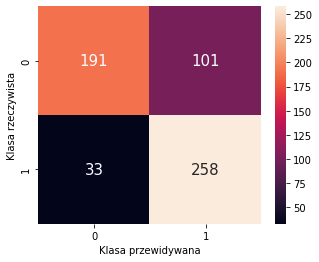

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.0f', annot_kws={'fontsize': 15})
plt.ylabel('Klasa rzeczywista')
plt.xlabel('Klasa przewidywana')
plt.show(block=False)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.65      0.74       292
           1       0.72      0.89      0.79       291

    accuracy                           0.77       583
   macro avg       0.79      0.77      0.77       583
weighted avg       0.79      0.77      0.77       583



In [ ]:
def print_metrics(y_true, y_pred, y_proba):
  print("AP micro: ", average_precision_score(y_test, y_pred, average='micro')) 
  print("AP macro: ", average_precision_score(y_test, y_pred, average='macro'), '\n') 

  print("f1 micro: ", f1_score(y_test, y_pred, average='micro')) 
  print("f1 macro: ", f1_score(y_test, y_pred, average='macro')) 
  print("f1 binary: ", f1_score(y_test, y_pred, average='binary'), '\n') 

  print("precision micro: ", precision_score(y_test, y_pred, average='micro')) 
  print("precision macro: ", precision_score(y_test, y_pred, average='macro')) 
  print("precision binary: ", precision_score(y_test, y_pred, average='binary'), '\n') 

  print("recall micro: ", recall_score(y_test, y_pred, average='micro')) 
  print("recall macro: ", recall_score(y_test, y_pred, average='macro')) 
  print("recall binary: ", recall_score(y_test, y_pred, average='binary'), '\n') 

  print("accuracy: ", accuracy_score(y_test, y_pred)) 
  print("log_loss: ", log_loss(y_test, y_proba)) 
  print("brier_score_loss: ", brier_score_loss(y_test, y_pred)) 
  

In [ ]:
print_metrics(y_test, y_pred, y_pred_p)

AP micro:  0.6937688656217779
AP macro:  0.6937688656217779 

f1 micro:  0.7701543739279588
f1 macro:  0.7670781156827668
f1 binary:  0.7938461538461539 

precision micro:  0.7701543739279588
precision macro:  0.7856707620374055
precision binary:  0.7186629526462396 

recall micro:  0.7701543739279588
recall macro:  0.7703537635927129
recall binary:  0.8865979381443299 

accuracy:  0.7701543739279588
log_loss:  0.48010115011215027
brier_score_loss:  0.22984562607204118


## DecisionTree - optuna

In [ ]:
def objective(trial):
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  splitter = trial.suggest_categorical('splitter', ['best', 'random'])
  max_depth = trial.suggest_categorical('max_depth', [None, 1, 2, 3])
  min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
  #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
  min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.000001, 0.1)
  max_features = trial.suggest_categorical('max_features', [None, 'auto', 'sqrt', 'log2'])
  random_state = trial.suggest_categorical('random_state', [None, 42])
  #trial.suggest_int('random_state', 0, 50)
  min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.000001, 0.1)
  class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
  ccp_alpha = trial.suggest_float('ccp_alpha', 0.000001, 0.1)

  clf = DecisionTreeClassifier(criterion=criterion, 
                               splitter=splitter, 
                               max_depth=max_depth, 
                               min_samples_split=min_samples_split,
                               #min_samples_leaf=min_samples_leaf,
                               min_weight_fraction_leaf=min_weight_fraction_leaf,
                               max_features=max_features,
                               random_state=random_state,
                               min_impurity_decrease=min_impurity_decrease,
                               class_weight=class_weight,
                               ccp_alpha=ccp_alpha
                               )
  clf.fit(X_train, y_train)
  accuracy = clf.score(X_test, y_test)

  return accuracy

with tf.device("/device:GPU:0"):
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=1000)

[I 2022-09-06 06:38:56,612] A new study created in memory with name: no-name-6dc23813-6793-4059-a3fd-6219eeeecbf6
[I 2022-09-06 06:38:56,624] Trial 0 finished with value: 0.5008576329331046 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': None, 'min_samples_split': 14, 'min_weight_fraction_leaf': 0.08728096732039028, 'max_features': 'sqrt', 'random_state': 42, 'min_impurity_decrease': 0.037636713116112226, 'class_weight': 'balanced', 'ccp_alpha': 0.07131729989558087}. Best is trial 0 with value: 0.5008576329331046.
[I 2022-09-06 06:38:56,632] Trial 1 finished with value: 0.7084048027444254 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': None, 'min_samples_split': 11, 'min_weight_fraction_leaf': 0.05022937401871866, 'max_features': 'auto', 'random_state': None, 'min_impurity_decrease': 0.021408187752990776, 'class_weight': 'balanced', 'ccp_alpha': 0.04067763248058505}. Best is trial 1 with value: 0.7084048027444254.
[I 2022-09-06 06:38:56,640

In [ ]:
study.best_params #0.7564322469982847

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 3,
 'min_samples_leaf': 18,
 'min_weight_fraction_leaf': 0.060619422495028705,
 'max_features': 'sqrt',
 'random_state': 26,
 'min_impurity_decrease': 0.011438850946774529,
 'class_weight': 'balanced',
 'ccp_alpha': 0.02395784936649664}

In [ ]:
study.best_params #0.758147512864494

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 4,
 'min_samples_leaf': 8,
 'min_weight_fraction_leaf': 0.02920340996514735,
 'max_features': 'sqrt',
 'random_state': 2,
 'min_impurity_decrease': 0.010766185389300012,
 'class_weight': None,
 'ccp_alpha': 0.025291268549228498}

## DecisionTree

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [ ]:
params = {'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 4,
 'min_samples_leaf': 8,
 'min_weight_fraction_leaf': 0.02920340996514735,
 'max_features': 'sqrt',
 'random_state': 2,
 'min_impurity_decrease': 0.010766185389300012,
 'class_weight': None,
 'ccp_alpha': 0.025291268549228498}

In [ ]:
clf = DecisionTreeClassifier(**params)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.758147512864494


In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_pred_p = clf.predict_proba(X_test)
y_pred_p

array([[0.71193416, 0.28806584],
       [0.30254237, 0.69745763],
       [0.06382979, 0.93617021],
       ...,
       [0.96911197, 0.03088803],
       [0.30254237, 0.69745763],
       [0.71193416, 0.28806584]])

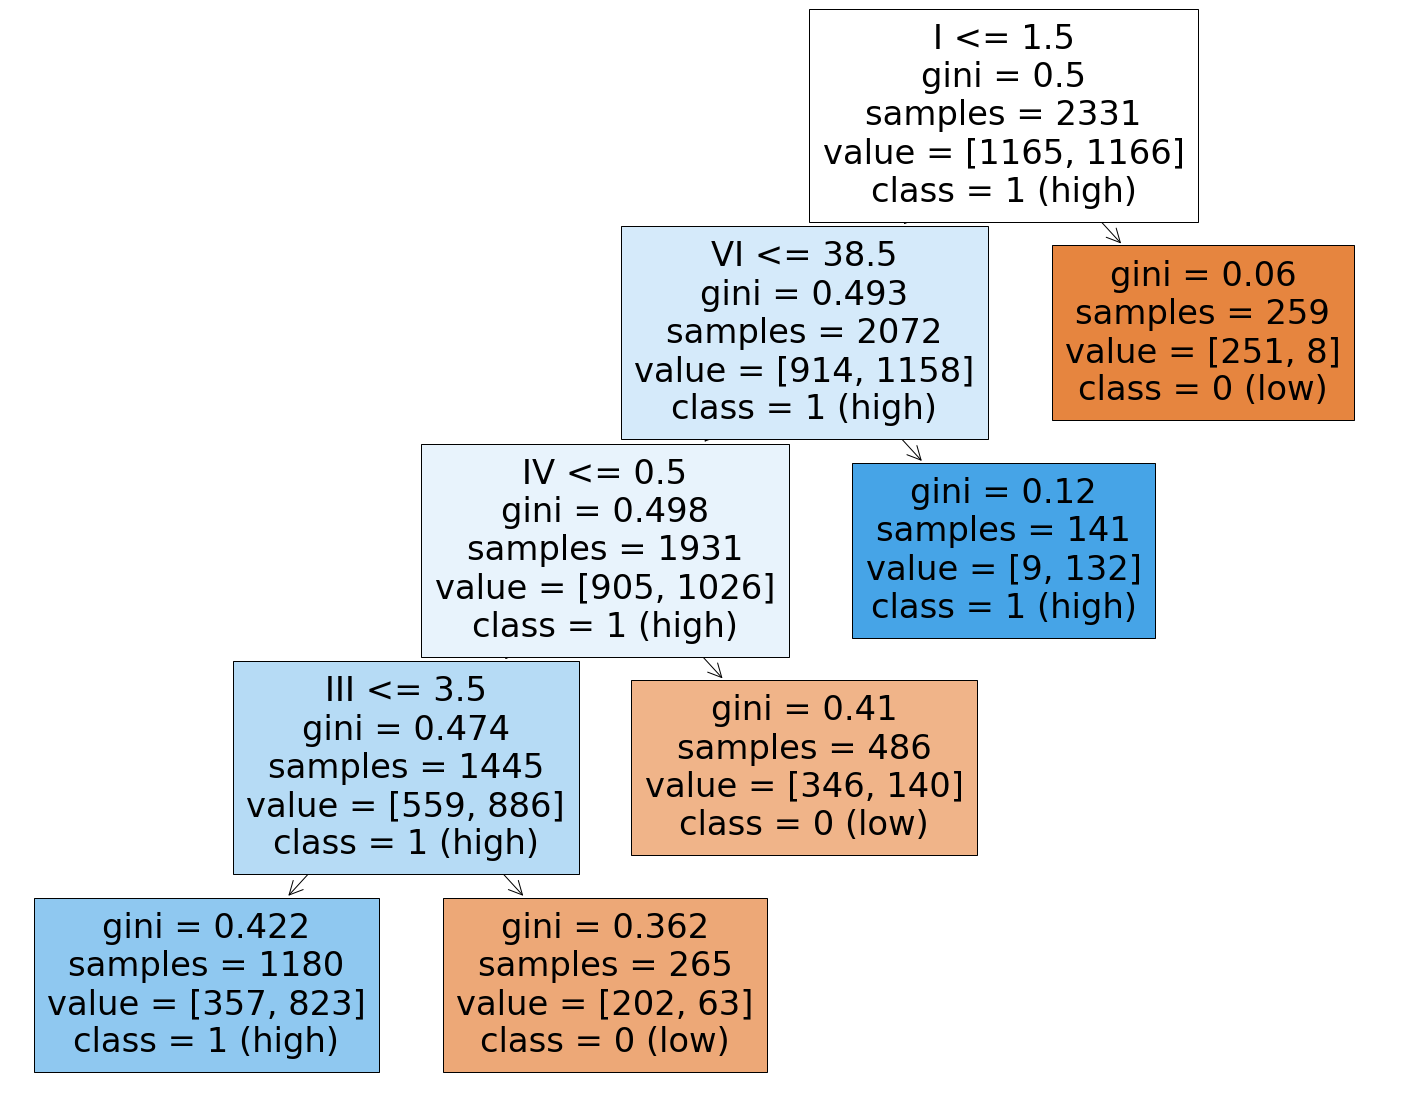

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=['I', 'II', 'III', 'IV', 'V', 'VI'], #['0', '1', '2', '3', '4', '5'],  
                   class_names=['0 (low)', '1 (high)'],
                   filled=True)

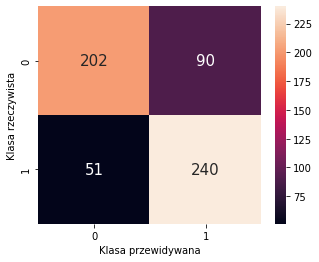

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.0f', annot_kws={'fontsize': 15})
plt.ylabel('Klasa rzeczywista')
plt.xlabel('Klasa przewidywana')
plt.show(block=False)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.69      0.74       292
           1       0.73      0.82      0.77       291

    accuracy                           0.76       583
   macro avg       0.76      0.76      0.76       583
weighted avg       0.76      0.76      0.76       583



In [ ]:
def print_metrics(y_true, y_pred, y_proba):
  print("AP micro: ", average_precision_score(y_test, y_pred, average='micro')) 
  print("AP macro: ", average_precision_score(y_test, y_pred, average='macro'), '\n') 

  print("f1 micro: ", f1_score(y_test, y_pred, average='micro')) 
  print("f1 macro: ", f1_score(y_test, y_pred, average='macro')) 
  print("f1 binary: ", f1_score(y_test, y_pred, average='binary'), '\n') 

  print("precision micro: ", precision_score(y_test, y_pred, average='micro')) 
  print("precision macro: ", precision_score(y_test, y_pred, average='macro')) 
  print("precision binary: ", precision_score(y_test, y_pred, average='binary'), '\n') 

  print("recall micro: ", recall_score(y_test, y_pred, average='micro')) 
  print("recall macro: ", recall_score(y_test, y_pred, average='macro')) 
  print("recall binary: ", recall_score(y_test, y_pred, average='binary'), '\n') 

  print("accuracy: ", accuracy_score(y_test, y_pred)) 
  print("log_loss: ", log_loss(y_test, y_proba)) 
  print("brier_score_loss: ", brier_score_loss(y_test, y_pred)) 
  

In [ ]:
print_metrics(y_test, y_pred, y_pred_p)

AP micro:  0.6872911177521175
AP macro:  0.6872911177521175 

f1 micro:  0.758147512864494
f1 macro:  0.7571156317865532
f1 binary:  0.7729468599033816 

precision micro:  0.758147512864494
precision macro:  0.7628458498023716
precision binary:  0.7272727272727273 

recall micro:  0.758147512864494
recall macro:  0.7582615449795227
recall binary:  0.8247422680412371 

accuracy:  0.758147512864494
log_loss:  0.5248176999189575
brier_score_loss:  0.241852487135506


# Rp

## Load model for structure classification (EfficientNet-B0)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y) 

In [ ]:
struct_model = models.load_model('drive/MyDrive/mgr/saved_models/3m_ef0_structures', custom_objects={"get_f1": get_f1})

In [ ]:
#print(classification_report(y_test, argmax(struct_model.predict(X_test), axis=1).numpy())) 

## Load dictionary - {image_path : structures_list}

In [ ]:
## dict {image : list_of_subimages}
# load low_Rp & high_Rp
low_Rp_dict = open_dict(os.path.join(DATA_DIR, 'files_dict_low_Rp.pkl'))
high_Rp_dict = open_dict(os.path.join(DATA_DIR, 'files_dict_high_Rp.pkl'))

# Rp_dict = merge_dict(low_Rp_dict, high_Rp_dict)
#len(Rp_dict) #2914

In [ ]:
## dict {image : dict_of_subimages {subimage_name : matrix} }
# load low_Rp & high_Rp structures
struct_low_Rp_dict = open_dict(os.path.join(DATA_DIR, 'structures_dict_low_Rp.pkl'))
struct_high_Rp_dict = open_dict(os.path.join(DATA_DIR, 'structures_dict_high_Rp.pkl'))

#struct_Rp_dict = merge_dict(struct_low_Rp_dict, struct_high_Rp_dict)
#len(struct_Rp_dict)

## Classify structures

In [ ]:
def predict_structures(files_dict, images_dict):
  structures_count = {}

  for key, values in files_dict.items(): #d1
    structures_count[key] = [0, 0, 0, 0, 0, 0]

    for value in values:
      if value!='':
        val = value.split('/')[1]
        X_struct_matrix = images_dict[key][val] #d1
        X_struct_matrix = cv.cvtColor(X_struct_matrix,cv.COLOR_GRAY2BGR)
        #plt.figure()
        #plt.imshow(X_struct_matrix)
        
        X_struct_matrix = np.array([X_struct_matrix])
        y_pred_struct = argmax(struct_model.predict(X_struct_matrix), axis=1).numpy()[0]

        structures_count[key][y_pred_struct] += 1

  return structures_count

In [ ]:
# count structures low Rp
STRUCT_COUNTS_TO_FILE_LOW_RP_DIR = os.path.join(DATA_DIR, 'structures_count_dict_low_Rp.pkl')

structures_count_low_Rp = predict_structures(low_Rp_dict, struct_low_Rp_dict)

# len(structures_count_low_Rp) - 1013

# save_dict(STRUCT_COUNTS_TO_FILE_LOW_RP_DIR, structures_count_low_Rp)

In [ ]:
# count structures high Rp
STRUCT_COUNTS_TO_FILE_HIGH_RP_DIR = os.path.join(DATA_DIR, 'structures_count_dict_high_Rp.pkl')

structures_count_high_Rp = predict_structures(high_Rp_dict, struct_high_Rp_dict)

# len(structures_count_high_Rp) - 663

# save_dict(STRUCT_COUNTS_TO_FILE_HIGH_RP_DIR, structures_count_high_Rp)

In [ ]:
# open dictionaries
STRUCT_COUNTS_TO_FILE_LOW_RP_DIR = os.path.join(DATA_DIR, 'structures_count_dict_low_Rp.pkl')
STRUCT_COUNTS_TO_FILE_HIGH_RP_DIR = os.path.join(DATA_DIR, 'structures_count_dict_high_Rp.pkl')

structures_count_low_Rp = open_dict(STRUCT_COUNTS_TO_FILE_LOW_RP_DIR)
structures_count_high_Rp = open_dict(STRUCT_COUNTS_TO_FILE_HIGH_RP_DIR)

In [ ]:
# merge dictionaries and save
STRUCT_COUNTS_TO_FILE_RP_DIR = os.path.join(DATA_DIR, 'structures_count_dict_Rp.pkl')

structures_count_Rp = merge_dict(structures_count_low_Rp, structures_count_high_Rp)

save_dict(STRUCT_COUNTS_TO_FILE_RP_DIR, structures_count_Rp)

## Load & prepare data for binary classification

In [ ]:
STRUCT_COUNTS_TO_FILE_RP_DIR = os.path.join(DATA_DIR, 'structures_count_dict_Rp.pkl')

structures_count_Rp = open_dict(STRUCT_COUNTS_TO_FILE_RP_DIR)

len(structures_count_Rp) # 1676

1676

In [ ]:
def convert_cat_Rp(text_cat):
  if text_cat=='low_Rp':
    nb_cat = 0
  elif text_cat=='high_Rp':
    nb_cat = 1

  return nb_cat

In [ ]:
def prepare_data(df):
  X = []
  y = []
  for i, data in df.iterrows():
    category = convert_cat_Rp(data.filename.split('/')[-2])

    X.append(data.struct_count)
    y.append(category)

  X = np.array(X)
  y = np.array(y)

  return X, y

In [ ]:
df_Rp = pd.DataFrame(structures_count_Rp.items(), columns=['filename', 'struct_count'])

In [ ]:
X, y = prepare_data(df_Rp)

## SVM - optuna

In [ ]:
def objective(trial):
  c = trial.suggest_float('C', 0.1, 10)
  kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
  degree = trial.suggest_int('degree', 0, 5)
  gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

  svc_opt = SVC(C=c, kernel=kernel, degree=degree, gamma=gamma)
  svc_opt.fit(X_train, y_train)
  accuracy = svc_opt.score(X_test, y_test)

  return accuracy

#with tf.device("/device:GPU:0"):
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-08-29 18:33:24,062] A new study created in memory with name: no-name-db8f853e-40b7-4e24-8dde-af9830c260e2
[I 2022-08-29 18:33:24,208] Trial 0 finished with value: 0.5300171526586621 and parameters: {'C': 7.0254502789244055, 'kernel': 'sigmoid', 'degree': 5, 'gamma': 'scale'}. Best is trial 0 with value: 0.5300171526586621.
[I 2022-08-29 18:33:24,460] Trial 1 finished with value: 0.7358490566037735 and parameters: {'C': 5.029478915875305, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto'}. Best is trial 1 with value: 0.7358490566037735.
[I 2022-08-29 18:33:25,761] Trial 2 finished with value: 0.6655231560891939 and parameters: {'C': 6.601051735083841, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 1 with value: 0.7358490566037735.
[I 2022-08-29 18:33:26,661] Trial 3 finished with value: 0.7684391080617495 and parameters: {'C': 4.080915902715985, 'kernel': 'linear', 'degree': 3, 'gamma': 'auto'}. Best is trial 3 with value: 0.7684391080617495.
[I 2022-08-29 18:33:26,

In [ ]:
study.best_params

{'C': 5.2573593646256525, 'kernel': 'poly', 'degree': 1, 'gamma': 'scale'}

In [ ]:
def objective(trial):
  c = trial.suggest_float('C', 0.1, 10)
  kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
  degree = trial.suggest_int('degree', 0, 5)
  gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

  svc_opt = SVC(C=c, kernel=kernel, degree=degree, gamma=gamma)
  svc_opt.fit(X_train, y_train)

  y_pred = svc_opt.predict(X_test)
  f1_sc = f1_score(y_test, y_pred, average='macro')
  return f1_sc

#with tf.device("/device:GPU:0"):
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-08-29 21:34:35,892] A new study created in memory with name: no-name-d7c07749-5ae6-4639-83b4-5d3af7dc8b83
[I 2022-08-29 21:34:36,485] Trial 0 finished with value: 0.4045112781954887 and parameters: {'C': 4.9798355565197125, 'kernel': 'linear', 'degree': 3, 'gamma': 'scale'}. Best is trial 0 with value: 0.4045112781954887.
[I 2022-08-29 21:34:36,621] Trial 1 finished with value: 0.6579273639964922 and parameters: {'C': 8.944315902101993, 'kernel': 'rbf', 'degree': 4, 'gamma': 'scale'}. Best is trial 1 with value: 0.6579273639964922.
[I 2022-08-29 22:05:22,845] Trial 2 finished with value: 0.5582660774933352 and parameters: {'C': 5.886357100699162, 'kernel': 'poly', 'degree': 4, 'gamma': 'auto'}. Best is trial 1 with value: 0.6579273639964922.
[I 2022-08-29 22:05:22,913] Trial 3 finished with value: 0.6503285312002611 and parameters: {'C': 5.333154588712958, 'kernel': 'rbf', 'degree': 5, 'gamma': 'scale'}. Best is trial 1 with value: 0.6579273639964922.
[I 2022-08-29 22:05:22,960

In [ ]:
 study.best_params

{'C': 9.065708850101503, 'kernel': 'rbf', 'degree': 4, 'gamma': 'scale'}

## SVM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [ ]:
clf = SVC(kernel='rbf', gamma='scale', degree=4, C=9,  probability=True)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.7023809523809523


In [ ]:
y_pred = clf.predict(X_test)


In [ ]:
y_pred_p = clf.predict_proba(X_test)
y_pred_p

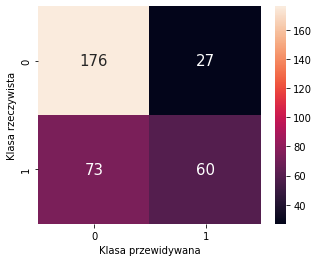

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.0f', annot_kws={'fontsize': 15})
plt.ylabel('Klasa rzeczywista')
plt.xlabel('Klasa przewidywana')
plt.show(block=False)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.87      0.78       203
           1       0.69      0.45      0.55       133

    accuracy                           0.70       336
   macro avg       0.70      0.66      0.66       336
weighted avg       0.70      0.70      0.69       336



In [ ]:
def print_metrics(y_true, y_pred, y_proba):
  print("AP micro: ", average_precision_score(y_test, y_pred, average='micro')) 
  print("AP macro: ", average_precision_score(y_test, y_pred, average='macro'), '\n') 

  print("f1 micro: ", f1_score(y_test, y_pred, average='micro')) 
  print("f1 macro: ", f1_score(y_test, y_pred, average='macro')) 
  print("f1 binary: ", f1_score(y_test, y_pred, average='binary'), '\n') 

  print("precision micro: ", precision_score(y_test, y_pred, average='micro')) 
  print("precision macro: ", precision_score(y_test, y_pred, average='macro')) 
  print("precision binary: ", precision_score(y_test, y_pred, average='binary'), '\n') 

  print("recall micro: ", recall_score(y_test, y_pred, average='micro')) 
  print("recall macro: ", recall_score(y_test, y_pred, average='macro')) 
  print("recall binary: ", recall_score(y_test, y_pred, average='binary'), '\n') 

  print("accuracy: ", accuracy_score(y_test, y_pred)) 
  print("log_loss: ", log_loss(y_test, y_proba)) 
  print("brier_score_loss: ", brier_score_loss(y_test, y_pred)) 
  

In [ ]:
print_metrics(y_test, y_pred, y_pred_p)

AP micro:  0.5283845389335408
AP macro:  0.5283845389335408 

f1 micro:  0.7023809523809523
f1 macro:  0.662107803700724
f1 binary:  0.5454545454545454 

precision micro:  0.7023809523809523
precision macro:  0.6982412408253704
precision binary:  0.6896551724137931 

recall micro:  0.7023809523809523
recall macro:  0.6590614467202489
recall binary:  0.45112781954887216 

accuracy:  0.7023809523809523
log_loss:  0.5851649575624679
brier_score_loss:  0.2976190476190476


## DecisionTree - optuna

In [ ]:
def objective(trial):
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  splitter = trial.suggest_categorical('splitter', ['best', 'random'])
  max_depth = trial.suggest_categorical('max_depth', [None, 1, 2, 3])
  min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
  min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.000001, 0.1)
  max_features = trial.suggest_categorical('max_features', [None, 'auto', 'sqrt', 'log2'])
  #random_state = trial.suggest_categorical('random_state', [None, 42])
  random_state = trial.suggest_int('random_state', 0, 50)
  min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.000001, 0.1)
  class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
  ccp_alpha = trial.suggest_float('ccp_alpha', 0.000001, 0.1)

  clf = DecisionTreeClassifier(criterion=criterion, 
                               splitter=splitter, 
                               max_depth=max_depth, 
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               min_weight_fraction_leaf=min_weight_fraction_leaf,
                               max_features=max_features,
                               random_state=random_state,
                               min_impurity_decrease=min_impurity_decrease,
                               class_weight=class_weight,
                               ccp_alpha=ccp_alpha
                               )
  clf.fit(X_train, y_train)
  accuracy = clf.score(X_test, y_test)

  return accuracy

with tf.device("/device:GPU:0"):
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=1000)

[I 2022-09-06 08:27:28,804] A new study created in memory with name: no-name-cd46f35f-b2ff-40ca-9f39-b1c51194110a
[I 2022-09-06 08:27:28,816] Trial 0 finished with value: 0.6041666666666666 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 20, 'min_weight_fraction_leaf': 0.03976555476241486, 'max_features': None, 'random_state': 34, 'min_impurity_decrease': 0.051931759572667525, 'class_weight': None, 'ccp_alpha': 0.04185377705360947}. Best is trial 0 with value: 0.6041666666666666.
[I 2022-09-06 08:27:28,823] Trial 1 finished with value: 0.3958333333333333 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0525086317215486, 'max_features': 'sqrt', 'random_state': 9, 'min_impurity_decrease': 0.015724377552093823, 'class_weight': 'balanced', 'ccp_alpha': 0.015934430352244233}. Best is trial 0 with value: 0.60416666

In [ ]:
study.best_params 

{'criterion': 'entropy',
 'splitter': 'random',
 'max_depth': 2,
 'min_samples_split': 19,
 'min_samples_leaf': 20,
 'min_weight_fraction_leaf': 0.03976555476241486,
 'max_features': None,
 'random_state': 34,
 'min_impurity_decrease': 0.051931759572667525,
 'class_weight': None,
 'ccp_alpha': 0.04185377705360947}

In [ ]:
def objective(trial):
  max_depth = trial.suggest_int('max_depth', 1, 25)
  
  clf = DecisionTreeClassifier(criterion= 'entropy',
                               splitter= 'best',                         
                               min_samples_split=19,
                               max_features= None,
                               max_depth=max_depth
                               )
  clf.fit(X_train, y_train)
  accuracy = clf.score(X_test, y_test)

  return accuracy

with tf.device("/device:GPU:0"):
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=100)

[I 2022-09-06 10:18:29,448] A new study created in memory with name: no-name-990c9e22-d7f3-4ac6-bc7d-fe25dfc39829
[I 2022-09-06 10:18:29,457] Trial 0 finished with value: 0.6041666666666666 and parameters: {'max_depth': 1}. Best is trial 0 with value: 0.6041666666666666.
[I 2022-09-06 10:18:29,464] Trial 1 finished with value: 0.6130952380952381 and parameters: {'max_depth': 2}. Best is trial 1 with value: 0.6130952380952381.
[I 2022-09-06 10:18:29,471] Trial 2 finished with value: 0.6577380952380952 and parameters: {'max_depth': 5}. Best is trial 2 with value: 0.6577380952380952.
[I 2022-09-06 10:18:29,481] Trial 3 finished with value: 0.6755952380952381 and parameters: {'max_depth': 18}. Best is trial 3 with value: 0.6755952380952381.
[I 2022-09-06 10:18:29,488] Trial 4 finished with value: 0.6607142857142857 and parameters: {'max_depth': 17}. Best is trial 3 with value: 0.6755952380952381.
[I 2022-09-06 10:18:29,496] Trial 5 finished with value: 0.6755952380952381 and parameters: {'

In [ ]:
study.best_params 

{'max_depth': 8}

In [ ]:
def objective(trial):
  max_depth = trial.suggest_int('max_depth', 1, 25)
  
  clf = DecisionTreeClassifier(criterion= 'entropy',
                               splitter= 'best',                         
                               min_samples_split=19,
                               max_features= None,
                               max_depth=max_depth
                               )
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  f1_sc = f1_score(y_test, y_pred, average='macro')

  return f1_sc

with tf.device("/device:GPU:0"):
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=1000)  
  

[I 2022-09-06 16:10:35,869] A new study created in memory with name: no-name-20895611-f06a-43d5-a376-1f6c228805f7
[I 2022-09-06 16:10:35,878] Trial 0 finished with value: 0.611111111111111 and parameters: {'max_depth': 9}. Best is trial 0 with value: 0.611111111111111.
[I 2022-09-06 16:10:35,892] Trial 1 finished with value: 0.6576140304953865 and parameters: {'max_depth': 10}. Best is trial 1 with value: 0.6576140304953865.
[I 2022-09-06 16:10:35,897] Trial 2 finished with value: 0.4196120116927983 and parameters: {'max_depth': 2}. Best is trial 1 with value: 0.6576140304953865.
[I 2022-09-06 16:10:35,904] Trial 3 finished with value: 0.6576140304953865 and parameters: {'max_depth': 10}. Best is trial 1 with value: 0.6576140304953865.
[I 2022-09-06 16:10:35,912] Trial 4 finished with value: 0.658955109544967 and parameters: {'max_depth': 7}. Best is trial 4 with value: 0.658955109544967.
[I 2022-09-06 16:10:35,920] Trial 5 finished with value: 0.6576140304953865 and parameters: {'max_

## DecisionTree

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [ ]:
params = {'criterion': 'entropy',
 'splitter': 'best',
 'max_depth': 8,
 'min_samples_split': 19,
 #'min_samples_leaf': 20,
 #'min_weight_fraction_leaf': 0.03976555476241486,
 'max_features': None,}
 #'random_state': 34,}
 #'min_impurity_decrease': 0.051931759572667525,
 #'class_weight': None,
 #'ccp_alpha': 0.04185377705360947}

In [ ]:
clf = DecisionTreeClassifier(**params)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy) 

0.6845238095238095


In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_pred_p = clf.predict_proba(X_test)
#y_pred_p

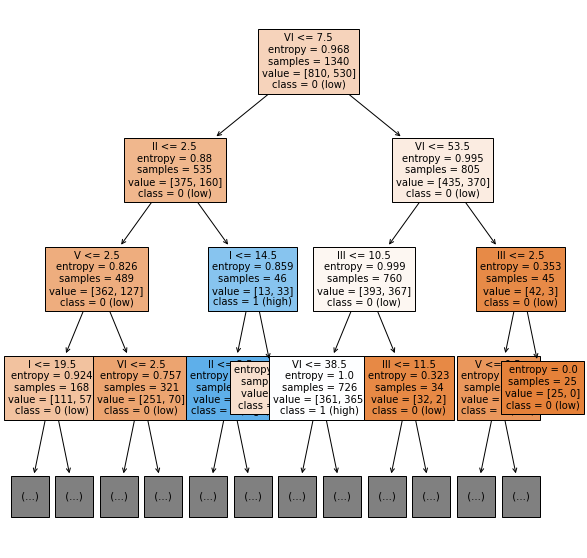

In [ ]:
fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(clf, 
                   feature_names=['I', 'II', 'III', 'IV', 'V', 'VI'], #['0', '1', '2', '3', '4', '5'], 
                   class_names=['0 (low)', '1 (high)'],
                   filled=True,
                   fontsize=10,
                   max_depth=3
                   )

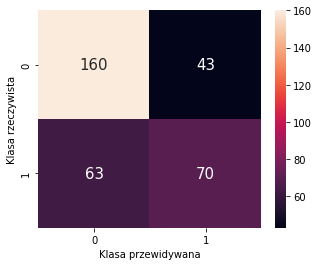

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.0f', annot_kws={'fontsize': 15})
plt.ylabel('Klasa rzeczywista')
plt.xlabel('Klasa przewidywana')
plt.show(block=False)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.79      0.75       203
           1       0.62      0.53      0.57       133

    accuracy                           0.68       336
   macro avg       0.67      0.66      0.66       336
weighted avg       0.68      0.68      0.68       336



In [ ]:
def print_metrics(y_true, y_pred, y_proba):
  print("AP micro: ", average_precision_score(y_test, y_pred, average='micro')) 
  print("AP macro: ", average_precision_score(y_test, y_pred, average='macro'), '\n') 

  print("f1 micro: ", f1_score(y_test, y_pred, average='micro')) 
  print("f1 macro: ", f1_score(y_test, y_pred, average='macro')) 
  print("f1 binary: ", f1_score(y_test, y_pred, average='binary'), '\n') 

  print("precision micro: ", precision_score(y_test, y_pred, average='micro')) 
  print("precision macro: ", precision_score(y_test, y_pred, average='macro')) 
  print("precision binary: ", precision_score(y_test, y_pred, average='binary'), '\n') 

  print("recall micro: ", recall_score(y_test, y_pred, average='micro')) 
  print("recall macro: ", recall_score(y_test, y_pred, average='macro')) 
  print("recall binary: ", recall_score(y_test, y_pred, average='binary'), '\n') 

  print("accuracy: ", accuracy_score(y_test, y_pred)) 
  print("log_loss: ", log_loss(y_test, y_proba)) 
  print("brier_score_loss: ", brier_score_loss(y_test, y_pred)) 
  

In [ ]:
print_metrics(y_test, y_pred, y_pred_p)

AP micro:  0.5135363297624592
AP macro:  0.5135363297624592 

f1 micro:  0.6845238095238095
f1 macro:  0.6601396999885492
f1 binary:  0.5691056910569106 

precision micro:  0.6845238095238095
precision macro:  0.6684789078931703
precision binary:  0.6194690265486725 

recall micro:  0.6845238095238095
recall macro:  0.657246564687581
recall binary:  0.5263157894736842 

accuracy:  0.6845238095238095
log_loss:  1.2695773268016464
brier_score_loss:  0.31547619047619047
